In [1]:
import os, sys, re, datetime, shutil, copy, json
import numpy as np
import astropy.units as u
import astropy.constants as const
import matplotlib
from astropy.table import Table
from collections import OrderedDict
from matplotlib import cm

def list2str(inlist, format_str = '{}'):
    return '[' + ', '.join([format_str.format(t) for t in inlist]) + ']'


In [2]:
# User-defined global parameters

X_CO_H2 = 1e-4
X_CI_CO = 0.2

list_of_T_kin_for_N_repISM = [15., 20., 25., 50., 50., 100., 100.] # T_kin in K for repISM
list_of_d_V_for_N_repISM = [3., 10., 25., 50., 40., 70., 90.] # d_V in km/s for repISM
#list_of_n_H2_for_N_repISM = [3.16e2, 3.16e2, 3.16e2, 1e3, 1e3, 1e3, 1e3] # n_H2 in cm^-3 for repISM
list_of_R_CI10CO21_for_N_repISM = [0.1, 0.1, 0.1, 0.2, 0.06, 0.1, 0.5]
list_of_I_CO10_range_for_N_repISM = [
    (30.,50.), (100.,200.), (350.,500.), (800.,1000.), 
    (700.,1000.), (1000.,1400.), (2000.,2200.) ] # K km s-1 for representative ISM conditions
list_of_I_CO10_for_N_repISM = np.array([
        np.mean(flux_pair) for flux_pair in list_of_I_CO10_range_for_N_repISM
    ])

global_list_of_T_kin = np.arange(6., 202., 1.) * u.K # for xgrid

# The alphaCO alphaCI T-only function are previously fitted using this code, 
# see the final formulae at the bottom of this code.
# The NLCorr is from "calc_NonLTE_RADEX_plot_alpha_{CO10,CO21,CI10}_correction_matrix.ipynb"
# Note: converting I_CO to N_H2: N_H2 = 0.624e20 * alphaCO * I_CO, no Helium.
# 
# func_alphaCO10_T_only = lambda T_ex: (0.131766 + (T_ex/75)**(2.12077)) * ((T_ex/75)**(-1.49619)) -0.431325
# func_alphaCO10_T_NLCorr = lambda T_kin, N_CO_d_V, n_H2: func_alphaCO10_T_only(T_kin) \
#                           * 0.525536 / ( 1.0 - np.exp( - (np.log10(n_H2) / 2.16907)**(2.37657) ) ) \
#                           * ( N_CO_d_V / 5.77837e+16 )**( 1.0 - np.exp( -(72.9268 / T_kin)**(1.81294) ) )
# func_alphaCO21_T_only = lambda T_ex: (0.0735232 + (T_ex/75)**(1.96531)) * ((T_ex/75)**(-1.96379)) -0.651211
# func_alphaCO21_T_NLCorr = lambda T_kin, N_CO_d_V, n_H2: func_alphaCO21_T_only(T_kin) \
#                           * 3.5174 / ( 1.0 - np.exp( - (np.log10(n_H2) / 2.58633)**(2.64749) ) ) \
#                           * ( N_CO_d_V / 5.95597e+17 )**( 1.0 - np.exp( -(22.4003 / T_kin)**(0.260518) ) )
# func_alphaCI10_T_only = lambda T_ex: (0.00835553 + (T_ex/75)**(4.75658)) * ((T_ex/75)**(-3.72792)) +10.7926
# func_alphaCI10_T_NLCorr = lambda T_kin, N_CI_d_V, n_H2: func_alphaCI10_T_only(T_kin) \
#                           * 0.977787 / ( 1.0 - np.exp( - ( \
#                             (np.log10(n_H2) - 1.3002 * np.log10(4.05052/T_kin)) / 3.66027 \
#                           )**(5.78891) ) )

# list_of_alphaCO10_for_N_repISM = np.array([
#         (func_alphaCO10_T_only(t) \
#          * (1e-4) / (X_CO_H2)) for t in list_of_T_kin_for_N_repISM
#     ])
# list_of_alphaCO21_for_N_repISM = np.array([
#         (func_alphaCO21_T_only(t) \
#          * (1e-4) / (X_CO_H2)) for t in list_of_T_kin_for_N_repISM
#     ])
# list_of_alphaCI10_for_N_repISM = np.array([
#         (func_alphaCI10_T_only(t) \
#          * (1e-4 * 0.2) / (X_CO_H2 * X_CI_CO)) for t in list_of_T_kin_for_N_repISM
#     ])
# list_of_I_CO10_for_N_repISM = np.array([
#         np.mean(flux_pair) for flux_pair in list_of_I_CO10_range_for_N_repISM
#     ])
# list_of_N_H2_for_N_repISM = 0.624e20 * list_of_alphaCO10_for_N_repISM * list_of_I_CO10_for_N_repISM
# print('list_of_N_CO_for_N_repISM', list2str(list_of_N_CO_for_N_repISM, '{:.3e}'))
# list_of_R_CI10CO21_calc = (list_of_alphaCI10_for_N_repISM / list_of_alphaCO21_for_N_repISM)
# print('list_of_I_CO10_for_N_repISM', list2str(list_of_I_CO10_for_N_repISM, '{:.3f}'))
# print('list_of_alphaCO10_for_N_repISM', list2str(list_of_alphaCO10_for_N_repISM, '{:.3f}'))
# print('list_of_alphaCO21_for_N_repISM', list2str(list_of_alphaCO21_for_N_repISM, '{:.3f}'))
# print('list_of_alphaCI10_for_N_repISM', list2str(list_of_alphaCI10_for_N_repISM, '{:.3f}'))
# print('list_of_N_H2_for_N_repISM', list2str(list_of_N_H2_for_N_repISM, '{:.3e}'))
# print('list_of_R_CI10CO21_for_N_repISM', list2str(list_of_R_CI10CO21_for_N_repISM, '{:.3f}'))
# print('list_of_R_CI10CO21_calc', list2str(list_of_R_CI10CO21_calc, '{:.3f}'))
# raise NotImplementedError()
# # recalculate with T-NLCorr
# recalc = 1
# for i in range(recalc):
#     list_of_alphaCO10_for_N_repISM = np.array([
#             (func_alphaCO10_T_NLCorr(t1, t2/t3, t4) \
#              * (1e-4) / (X_CO_H2)) for t1,t2,t3,t4 in \
#             list(zip(
#                 list_of_T_kin_for_N_repISM, 
#                 list_of_N_CO_for_N_repISM, 
#                 list_of_d_V_for_N_repISM, 
#                 list_of_n_H2_for_N_repISM, 
#             ))
#         ])
#     list_of_I_CO10_for_N_repISM = np.array([
#             np.mean(flux_pair) for flux_pair in list_of_I_CO10_range_for_N_repISM
#         ])
#     list_of_N_H2_for_N_repISM = 0.624e20 * list_of_alphaCO10_for_N_repISM * list_of_I_CO10_for_N_repISM
#     list_of_Sigma_H2_for_N_repISM = list_of_N_H2_for_N_repISM / 0.624e20
#     list_of_N_CO_for_N_repISM = list_of_N_H2_for_N_repISM * X_CO_H2
#     list_of_N_CI_for_N_repISM = list_of_N_CO_for_N_repISM * X_CI_CO # 0.2 times of N_CO
#     print('recalc {}'.format(i+1))
#     print('list_of_alphaCO10_for_N_repISM', list2str(list_of_alphaCO10_for_N_repISM, '{:.3f}'))
#     print('list_of_Sigma_H2_for_N_repISM', list2str(list_of_Sigma_H2_for_N_repISM, '{:.3f}'))
#     print('list_of_N_CO_for_N_repISM', list2str(list_of_N_CO_for_N_repISM, '{:.3e}'))
#     print('list_of_N_CI_for_N_repISM', list2str(list_of_N_CI_for_N_repISM, '{:.3e}'))
# list_of_Sigma_H2_for_N_repISM = list_of_N_H2_for_N_repISM / 0.624e20

# 20220326 
#list_of_alphaCO10_for_N_repISM = np.array([3.2, 3.2, 3.2, 3.2, 2.0, 2.0, 2.0]) # no helium
#list_of_N_H2_for_N_repISM = 0.624e20 * list_of_alphaCO10_for_N_repISM * list_of_I_CO10_for_N_repISM
# list_of_Sigma_H2_for_N_repISM = list_of_N_H2_for_N_repISM / 0.624e20

# 20220326 
list_of_Sigma_mol_for_N_repISM = np.array([
        140.0, # Inner Galactic GMC, from Roman-Duval et al. (2010), MW BU-FCRAO GRS of 13CO
        300.0, # NGC3627 disk GMC, value by my guessing.
               # Note that Watanabe et al. (2019), NGC3627 Spiral Arm 20K NCO 2.1e17, 
               # Bar End 20K NCO 3.7e17, Nucleus 20K NCO 5.8e17, but [CO/H2] ~ 1e-5
        400.0, # NGC3627 bar end, value by my guessing.
        800.0, # NGC1808 SB disk, value by my guessing.
        10**2.94, # NGC4321 center, from Sun et al. (2018) Fig. 1, assumed metalZ-dependent alphaCO
        10**2.971, # NGC3627 center, from Sun et al. (2018) Fig. 1, assumed metalZ-dependent alphaCO
        1500.0, # NGC7469 center, value by my guessing.
    ]) # with helium
list_of_Sigma_H2_for_N_repISM = list_of_Sigma_mol_for_N_repISM / 1.36 # no helium
list_of_alphaCO10_for_N_repISM = list_of_Sigma_H2_for_N_repISM / list_of_I_CO10_for_N_repISM # no helium
list_of_N_H2_for_N_repISM = list_of_Sigma_H2_for_N_repISM * 0.624e20

# 20220326 (3) -- all normalize to NCO/dV=2.67e17
# list_of_N_CO_for_N_repISM = np.full(len(list_of_T_kin_for_N_repISM), fill_value=2.67e17) * \
#                             np.array(list_of_d_V_for_N_repISM)
# list_of_N_H2_for_N_repISM = list_of_N_CO_for_N_repISM / X_CO_H2
# list_of_Sigma_H2_for_N_repISM = list_of_N_H2_for_N_repISM / 0.624e20
# list_of_alphaCO10_for_N_repISM = list_of_Sigma_H2_for_N_repISM / list_of_I_CO10_for_N_repISM # no helium


list_of_N_CO_for_N_repISM = list_of_N_H2_for_N_repISM * X_CO_H2
list_of_N_CI_for_N_repISM = list_of_N_CO_for_N_repISM * X_CI_CO # 0.2 times of N_CO
print('list_of_alphaCO10_for_N_repISM', list2str(list_of_alphaCO10_for_N_repISM, '{:.3f}'))
print('list_of_Sigma_H2_for_N_repISM', list2str(list_of_Sigma_H2_for_N_repISM, '{:.3f}'))
print('list_of_Sigma_mol_for_N_repISM', list2str(list_of_Sigma_mol_for_N_repISM, '{:.3f}'))
print('list_of_N_H2_for_N_repISM', list2str(list_of_N_H2_for_N_repISM, '{:.3e}'))
print('list_of_N_CO_for_N_repISM', list2str(list_of_N_CO_for_N_repISM, '{:.3e}'))
print('list_of_N_CI_for_N_repISM', list2str(list_of_N_CI_for_N_repISM, '{:.3e}'))
print('list_of_N_CO_d_V_for_N_repISM', list2str(list_of_N_CO_for_N_repISM / np.array(list_of_d_V_for_N_repISM), 
                                                '{:.3e}'))


norm = matplotlib.colors.Normalize(vmin=18.05, vmax=19.35, 
                                   clip=True) # vmin=17.0+0.3, vmax=20.0-0.4, see 'calc_LTE_R_CI10CO21.ipynb'
cmap = cm.gist_rainbow_r
colormapper = cm.ScalarMappable(norm=norm, cmap=cmap)
list_of_linecolor_for_N_repISM = ['blue', '#1e90ff', '#1be5e4', 
                                  'green', 
                                  'orange', 'red', '#ff1e90' ] 
                                  # [colormapper.to_rgba(np.log10(t)) for t in global_list_of_N_CO]
list_of_linestyle_for_N_repISM = ['dashdot', 'solid', 'dashed', 
                                  'dotted', 
                                  {'loosely dashed': (0, (5, 10))}, 
                                  {'dotted': (0, (1, 3))}, 
                                  {'dotted': (0, (1, 1))} ]
list_of_linethick_for_N_repISM = [2.0, 2.0, 2.0, 
                                  1.5, 1.5, 1.5, 1.5]
list_of_linelabel_for_N_repISM = [None, None, None, 
                                  None, None, None, None]

z = 0.0 # redshift for T_CMB
#z = 2.0 # redshift for T_CMB


list_of_alphaCO10_for_N_repISM [2.574, 1.471, 0.692, 0.654, 0.753, 0.573, 0.525]
list_of_Sigma_H2_for_N_repISM [102.941, 220.588, 294.118, 588.235, 640.414, 687.798, 1102.941]
list_of_Sigma_mol_for_N_repISM [140.000, 300.000, 400.000, 800.000, 870.964, 935.406, 1500.000]
list_of_N_H2_for_N_repISM [6.424e+21, 1.376e+22, 1.835e+22, 3.671e+22, 3.996e+22, 4.292e+22, 6.882e+22]
list_of_N_CO_for_N_repISM [6.424e+17, 1.376e+18, 1.835e+18, 3.671e+18, 3.996e+18, 4.292e+18, 6.882e+18]
list_of_N_CI_for_N_repISM [1.285e+17, 2.753e+17, 3.671e+17, 7.341e+17, 7.992e+17, 8.584e+17, 1.376e+18]
list_of_N_CO_d_V_for_N_repISM [2.141e+17, 1.376e+17, 7.341e+16, 7.341e+16, 9.990e+16, 6.131e+16, 7.647e+16]


In [3]:
CO = {}
CO['Einstein_A'] = np.array([
    7.203e-08, 6.910e-07, 2.497e-06, 6.126e-06, 1.221e-05, 2.137e-05, 3.422e-05, 5.134e-05, 7.330e-05, 1.006e-04, 
    1.339e-04, 1.735e-04, 2.200e-04, 2.739e-04, 3.354e-04, 4.050e-04, 4.829e-04, 5.695e-04, 6.650e-04, 7.695e-04, 
    8.833e-04, 1.006e-03, 1.139e-03, 1.281e-03, 1.432e-03, 1.592e-03, 1.761e-03, 1.940e-03, 2.126e-03, 2.321e-03, 
    2.524e-03, 2.735e-03, 2.952e-03, 3.175e-03, 3.404e-03, 3.638e-03, 3.878e-03, 4.120e-03, 4.365e-03, 4.613e-03, 
])
CO['E_u'] = np.array([
    5.53,      16.60,   33.19,   55.32,   82.97,  116.16,  154.87,  199.11,  248.88, 304.16, 
    364.97,   431.29,  503.13,  580.49,  663.35,  751.72,  845.59,  944.97, 1049.84, 1160.20, 
    1276.05, 1397.38, 1524.19, 1656.47, 1794.23, 1937.44, 2086.12, 2240.24, 2399.82, 2564.83, 
    2735.28, 2911.15, 3092.45, 3279.15, 3471.27, 3668.78, 3871.69, 4079.98, 4293.64, 4512.67, 
])
CO['E_l'] = np.concatenate([
    [0.0], CO['E_u'][:-1]
])
CO['nu'] = np.array([
     115.2712018,  230.5380000,  345.7959899,  461.0407682,  576.2679305, 
     691.4730763,  806.6518060,  921.7997000, 1036.9123930, 1151.9854520, 
    1267.0144860, 1381.9951050, 1496.9229090, 1611.7935180, 1726.6025057, 
    1841.3455060, 1956.0181390, 2070.6159930, 2185.1346800, 2299.5698420, 
    2413.9171130, 2528.1720600, 2642.3303459, 2756.3875840, 2870.3394070, 
    2984.1814550, 3097.9093610, 3211.5187506, 3325.0052827, 3438.3646110, 
    3551.5923610, 3664.6841800, 3777.6357280, 3890.4427170, 4003.1007876, 
    4115.6055850, 4227.9527744, 4340.1381120, 4452.1571221, 4564.0056399, 
])

In [4]:
CI = {}
CI['Einstein_A'] = np.array([
    7.880E-08, 2.650E-07, 
    #1.810E-14, 
])
CI['E_u'] = np.array([
    23.620, 62.462, 
    # 62.462, 
])
CI['E_l'] = np.concatenate([
    [0.0], CI['E_u'][:-1]
])
CI['nu'] = np.array([
    492.160651, 809.34197, 
    # 1301.50262, 
])

In [5]:
def calc_Q(E_u, T_kin, N=None):
    E_j = np.concatenate([[0.0], E_u])
    if N is None:
        N = len(E_j)
    j = np.arange(N)
    E_j = E_j[0:N]
    #E_j = (j*(j+1)) * E_u[0]
    return np.sum(1.0 * (j+(j+1)) * np.exp(-1.0 * E_j / T_kin))

In [6]:
def calc_Bnu(
        nu, 
        T_ex, 
    ):
    c = const.c.cgs.value # 2.99792458e+10 cm / s
    pi = np.pi
    h = const.h.cgs.value # 6.62607015e-27 erg s
    k = const.k_B.cgs.value # 1.380649e-16 erg / K
    hnu_kt = h*(nu*1e9)/(k*T_ex)
    Bnu = 2*h*(nu*1e9)**3/c**2 * (1.0 / (np.exp(hnu_kt) - 1.0))
    return Bnu

def calc_tau(
        nu, 
        g_u, 
        E_u,
        Q, 
        A_ul, 
        N_dV, 
        T_ex, 
    ):
    c = const.c.cgs.value # 2.99792458e+10 cm / s
    pi = np.pi
    h = const.h.cgs.value # 6.62607015e-27 erg s
    k = const.k_B.cgs.value # 1.380649e-16 erg / K
    hnu_kt = h*(nu*1e9)/(k*T_ex)
    E_u_kt = E_u/T_ex
    N_dV_cm_2_km_s_1 = N_dV # input should have a unit of cm^{-2} (km s^{-1})^{-1}
    N_dV_cm_2_cm_s_1 = N_dV_cm_2_km_s_1 / 1e5 # km^{-1} to cm^{-1}
    return c**3/(8.0*pi*(nu*1e9)**3) * (g_u/Q) * A_ul \
           * np.exp(E_u_kt) \
           * N_dV_cm_2_cm_s_1 / 1.0645 \
           * (1.0 - np.exp( -hnu_kt ))



### Prepare function to fit the Q-E term

In [7]:
# define function to fit the Q-E term
from scipy.optimize import curve_fit

# def func_QE_term(T_ex, a, b, c, d, e):
#     if isinstance(T_ex, u.Quantity):
#         T_ex = T_ex.cgs.value
#     return (a * T_ex + b) * (c + d / T_ex**e)

# def latex_str_func_QE_term(a, b, c, d, e):
#     str_format = '({:.2f} * T_ex + {:.2f}) * ({:.2f} + {:.2f} / T_ex^{{{:.2f}}})'
#     latex_str = str_format.format(a, b, c, d, e)
#     latex_str = latex_str.replace('T_ex', r'T_{\mathrm{ex}}')
#     latex_str = latex_str.replace('*', r'\,')
#     latex_str = latex_str.replace('/', r'\,/\,')
#     return latex_str

# def lambda_str_func_QE_term(a, b, c, d, e):
#     str_format = 'lambda T_ex: ({:g} * T_ex + {:g}) * ({:g} + {:G} / T_ex**({:.2f}))'
#     latex_str = str_format.format(a, b, c, d, e)
#     return latex_str

# func_QE_CO = func_QE_term
# func_QE_CI = func_QE_term
# latex_str_func_QE_CO = latex_str_func_QE_term
# latex_str_func_QE_CI = latex_str_func_QE_term

# def fit_func_QE_CO(x, y):
#     popt, pcov = curve_fit(func_QE_term, x, y, p0=[0.2, 1.0, 1.0, 1.0, 1.2])
#     yfit = func_QE_term(x, *popt)
#     return popt, yfit

# def fit_func_QE_CI(x, y):
#     popt, pcov = curve_fit(func_QE_term, x, y, p0=[0.01, 1.0, 1.0, 1.0, 1.2]) # same as CO except for p0
#     yfit = func_QE_term(x, *popt)
#     return popt, yfit

# def fit_func_QE_CI_z2(x, y):
#     popt, pcov = curve_fit(func_QE_term, x, y, p0=[-1.0, 2.0, 0.0, 5.0, 2.0]) # same as CO except for p0
#     yfit = func_QE_term(x, *popt)
#     return popt, yfit

def func_QE_term(T_ex, a, b, c, d):
    if isinstance(T_ex, u.Quantity):
        T_ex = T_ex.cgs.value
    return (a * (T_ex/15.0) + b) * ((T_ex/15.0)**c + d)

def latex_str_func_QE_term(a, b, c, d):
    str_format = '[ {:.2f} * (T_ex/15) + {:.2f} ] * [ (T_ex/15)^{{{:.2f}}} + {:.2f} ]'
    latex_str = str_format.format(a, b, c, d)
    latex_str = latex_str.replace('T_ex', r'T_{\mathrm{ex}}')
    latex_str = latex_str.replace('*', r'\,')
    latex_str = latex_str.replace('/', r'\,/\,')
    return latex_str

def lambda_str_func_QE_term(a, b, c, d):
    str_format = 'lambda T_ex: ({:g} * (T_ex/15) + {:g}) * ((T_ex/15)**({:g}) + {:g})'
    latex_str = str_format.format(a, b, c, d)
    return latex_str

func_QE_CO = func_QE_term
func_QE_CI = func_QE_term
latex_str_func_QE_CO = latex_str_func_QE_term
latex_str_func_QE_CI = latex_str_func_QE_term

def fit_func_QE_CO(x, y, z = 0.0):
    if z >= 2.0:
        p0 = [2.0, 1.0, -2.5, 5.0]
    else:
        p0 = [0.8, 1.1, 0.1, 3.0]
    #popt, pcov = curve_fit(func_QE_term, x, y, p0 = p0)
    try:
        popt, pcov = curve_fit(func_QE_term, x, y, p0 = p0)
        fitokay = True
    except:
        popt = p0
        fitokay = False
    yfit = func_QE_term(x, *popt)
    return popt, yfit, fitokay

def fit_func_QE_CI(x, y, z = 0.0):
    if z >= 2.0:
        p0 = [0.1, 1.0, -2.5, 5.0]
    else:
        p0 = [0.1, 1.0, -1.0, 1.0]
    popt, pcov = curve_fit(func_QE_term, x, y, p0 = p0) # same as CO except for p0
    yfit = func_QE_term(x, *popt)
    return popt, yfit


### Prepare function to plot the Q-E term

In [8]:
# define function to plot one set of Q*ehnukt*Bnuratio vs. T_kin

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 11.5
matplotlib.rcParams['ytick.labelsize'] = 11.5
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['axes.formatter.useoffset'] = False
#matplotlib.rcParams['mathtext.fontset'] = 'custom'
#matplotlib.rcParams['mathtext.cal'] = 'stix:italic'
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker
import matplotlib.patheffects as path_effects

def set_xticks_log(ax):
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    #ax.xaxis.set_major_locator(ticker.LogLocator(base=10, subs=(1,2,3,5)))
    ax.grid(True, ls='dotted', lw=0.5, color='#777777', alpha=0.7)
    ax.set_xlim(ax.get_xlim())
    ax.set_xticks([5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 
                   60, 70, 80, 90, 100, 200])
    ax.set_xticklabels(['5', '', '', '', '', '10', '20', '30', '40', '50', 
                        '', '', '', '', '100', '200'])

def make_a_plot_for_Q_E_term_vs_T_kin(
        x, 
        Ju,
        z=0.0, 
        species='CO', 
        top_left_text=None, 
        out_fig_name=None, 
        return_popt=False,
    ):
    fig = plt.figure(figsize=(15,4))
    
    if species == 'CO':
        global CO
        species_moldata = CO
    elif species == 'CI':
        global CI
        species_moldata = CI
    else:
        raise Exception('Error! The input species must be either "CO" or "CI"!')
    
    # Computing coefficients to be shown in panels 1-3
    Q = np.array([calc_Q(species_moldata['E_u'], T_kin.value) for T_kin in x])
    nu = species_moldata['nu'][Ju-1] * u.GHz
    E_u = species_moldata['E_u'][Ju-1] * u.K
    hnuk = const.h.cgs * nu.cgs / const.k_B.cgs
    eElkt = np.exp(E_u / x)
    #print('Ju', Ju, 'eElkt', eElkt)
    ehnukt = np.exp(hnuk / x)
    ehnuktcmb = np.exp(hnuk / (2.73*u.K * (1.0+z)))
    Bnuratio = 1.0 / ( 1.0 - ( (ehnukt-1.0) / (ehnuktcmb-1.0) ) )
    y1 = Q * eElkt * Bnuratio
    y2 = Q
    y3 = eElkt * Bnuratio
    
    # Panel 1
    label1 = r'Coeff.: $ Q \; \mathrm{e}^{%.2f / T_{\mathrm{ex}}} \; / \; '%(E_u.value) + \
             r'\left[ 1 - ( \mathrm{e}^{%.2f / T_{\mathrm{ex}}} -1 ) \, / \, '%(hnuk.value) + \
             r'( \mathrm{e}^{%.2f / T_{\mathrm{CMB}}} - 1 ) \right] }$'%(hnuk.value)
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_xlabel(r'$T_{\mathrm{ex}} \ / \ [\mathrm{K}]$', fontsize=13, labelpad=3)
    ax1.set_ylabel(r'$Coefficients \ (as \ labelled)$', fontsize=13.5, labelpad=12)
    ax1.plot(x, y1, 
             color='C0', lw=2, alpha=0.9, 
             label=label1, 
             )
    set_xticks_log(ax1)
    ymin, ymax = ax1.get_ylim()
    if ymax > 100.:
        ax1.set_ylim([ymin, 100.])
    
    # Top left text in Panel 1
    if top_left_text is not None:
        if z > 0.0:
            top_left_text = copy.copy(top_left_text)
            top_left_text += ' $z = {:g}$'.format(z)
        tt1 = ax1.text(0.02, 0.96, top_left_text, fontsize=14, ha='left', va='top', transform=ax1.transAxes)
        tt1.set_path_effects([path_effects.Stroke(linewidth=0.6, foreground='black'), path_effects.Normal()])
    
    # Panel 2
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_xlabel(r'$T_{\mathrm{ex}} \ / \ [\mathrm{K}]$', fontsize=13)
    ax2.plot(x, y2, 
             color='C2', lw=2, alpha=0.9, 
             label=r'Coeff.: $Q$', 
            )
    set_xticks_log(ax2)
    
    # Panel 3
    label3 = r'Coeff.: $\mathrm{e}^{%.2f / T_{\mathrm{ex}}} \; / \; '%(E_u.value) + \
             r'\left[ 1 - ( \mathrm{e}^{%.2f / T_{\mathrm{ex}}} -1 ) \, / \, '%(hnuk.value) + \
             r'( \mathrm{e}^{%.2f / T_{\mathrm{CMB}}} - 1 ) \right] }$'%(hnuk.value)
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_xlabel(r'$T_{\mathrm{ex}} \ / \ [\mathrm{K}]$', fontsize=13)
    #ax3.set_ylabel(r'$\mathrm{e}^{h \nu/{(k_{\mathrm{B}} T_{\mathrm{ex}})}}$')
    ax3.plot(x, y3, 
             color='C1', lw=2, alpha=0.9, 
             label=label3, 
            )
    set_xticks_log(ax3)
    ax3.plot(ax3.get_xlim(), [1.0, 1.0], ls='dashed', lw=1.2, color='k', alpha=0.8, label='$y = 1.0$')
    
    # Overplot function lines in Panels
    if species == 'CO':
        ax1.set_ylim([0.0, ax1.get_ylim()[1]*1.05])
        # show the 2 T / E_1 function
        E_1 = 5.53
        overplot_func1a = lambda t: 2.0 * t / E_1 # 2 T / E_1
        ax1.plot(ax1.get_xlim(), overplot_func1a(np.array(ax1.get_xlim())), 
                 ls='dashed', lw=1.2, color='k', alpha=0.8, 
                 label=r'$y = 2 \, T_{\mathrm{ex}} \, / \, %s$'%(
                     E_1))
        ax2.plot(ax2.get_xlim(), overplot_func1a(np.array(ax2.get_xlim())), 
                 ls='dashed', lw=1.2, color='k', alpha=0.8, 
                 label=r'$y = 2 \, T_{\mathrm{ex}} \, / \, %.2f$'%(
                     E_1))
        
        #print('QE_CO function x:', repr(x))
        #print('QE_CO function y:', repr(y1))
        popt, fity1, fitokay = fit_func_QE_CO(x, y1, z = z)
        print('QE_CO function coefficients:', popt)
        label = r'$y \approx ' + latex_str_func_QE_CO(*popt)
        if fitokay:
            label += r' \ \, ({\it fitted})'
        else:
            label += r' \ \, ({\it nofit})'
        label += '$'
        ax1.plot(x, fity1, 
                 ls='dotted', lw=3, color='magenta', alpha=0.8, zorder=99, 
                 label=label)
    # 
    elif species == 'CI':
        ax1.set_ylim([0.0, ax1.get_ylim()[1]*1.50])
        # show a constant QE for CI between T_ex = 20 and 100
        interp_y1 = np.interp(np.arange(20., 100.+2., 2.), x.value, y1)
        overplot_ylow = np.min(interp_y1)
        overplot_yhigh = np.max(interp_y1)
        QE_mean = (overplot_ylow + overplot_yhigh)/2.0
        print('QE_CI10 mean:', QE_mean, 'over T_kin = 20 - 100 K')
        overplot_func1a = lambda t: t*0.0 + QE_mean # 2 T / E_1
        ax1.plot(ax1.get_xlim(), overplot_func1a(np.array(ax1.get_xlim())), 
                 ls='dashed', lw=1.2, color='k', alpha=0.8, 
                 label=r'$y = %.2f$'%(QE_mean))
        
        popt, fity1 = fit_func_QE_CI(x, y1, z = z)
        print('QE_CI function coefficients:', popt)
        ax1.plot(x, fity1, 
                 ls='dotted', lw=3, color='magenta', alpha=0.8, zorder=99, 
                 label=r'$y \approx ' + latex_str_func_QE_CI(*popt) + r' \ \, ({\it fitted})$')
    # 
    else:
        popt = None
        raise NotImplementedError()
    
    # print max diff
    diffy1 = (y1-fity1)/y1
    max_positive_diff_indices = np.argmax(diffy1).ravel()[0]
    max_negative_diff_indices = np.argmin(diffy1).ravel()[0]
    print('max diff positive x, y, yfit, (y-yfit)/y :', 
          x[max_positive_diff_indices], ',', 
          y1[max_positive_diff_indices], ',', 
          fity1[max_positive_diff_indices], ',', 
          diffy1[max_positive_diff_indices])
    print('max diff negative x, y, yfit, (y-yfit)/y :', 
          x[max_negative_diff_indices], ',', 
          y1[max_negative_diff_indices], ',', 
          fity1[max_negative_diff_indices], ',', 
          diffy1[max_negative_diff_indices])
    
    # Adjust panel axes
    ax1.legend(fontsize=13, bbox_to_anchor=(0.0, 1.0, 1.0, 0.2), loc='lower center')
    ax2.legend(fontsize=13, bbox_to_anchor=(0.0, 1.0, 1.0, 0.2), loc='lower center')
    ax3.legend(fontsize=13, bbox_to_anchor=(0.0, 1.0, 1.0, 0.2), loc='lower center')
    
    fig.tight_layout()
    
    if out_fig_name is not None:
        if z > 0.0:
            out_fig_name = copy.copy(out_fig_name)
            out_fig_name += '_z{:g}'.format(z)
        fig.savefig(out_fig_name+'.pdf', dpi=300)
        print('Output to "%s"'%(out_fig_name+'.pdf'))
    
    if return_popt:
        return fig, popt
    else:
        return fig


### Now we plot the Q-T term

T_CMB 2.73 K
coe1 258.2537558492139 1 / (cm3 K)
coe2 1195121272.845638 s / (cm3 K)
coe3 1.915452546725204e-06 s solMass / (K km pc2)
coe4 0.019154525467252038 s solMass / (K km pc2)
alphaCO10 function coefficients
QE_CO function coefficients: [1.18552131 1.05087698 0.13519638 3.04224372]
max diff positive x, y, yfit, (y-yfit)/y : 6.0 K , 8.27890334223904 , 5.987074350406871 , 0.276827605914812
max diff negative x, y, yfit, (y-yfit)/y : 23.0 K , 11.483971556861691 , 11.7665501155208 , -0.024606344352208712
Output to "Plot_LTE_alpha_CO10.pdf"


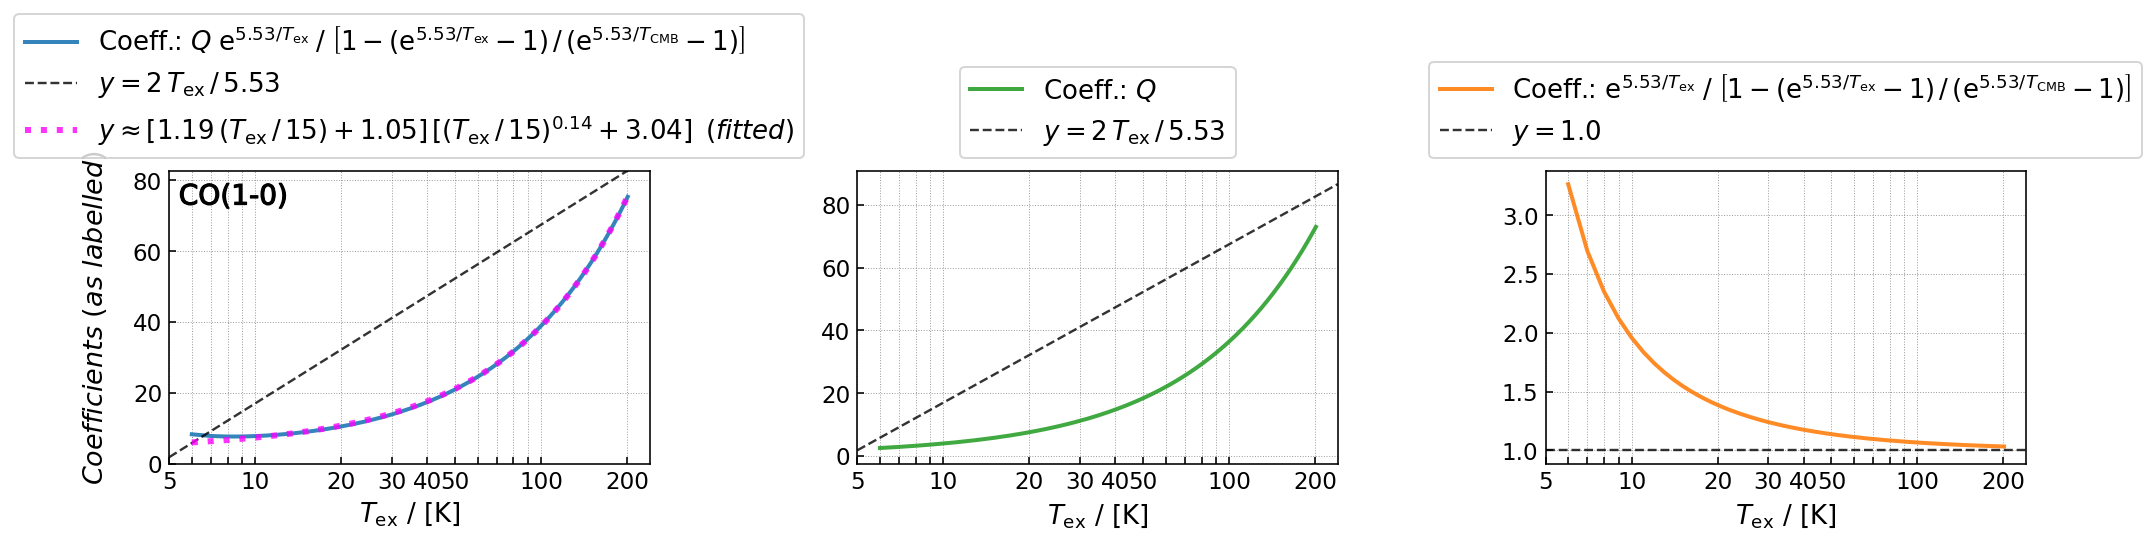

In [9]:
# CO10

if __name__ == '__main__' and '__file__' not in globals():
    
    #z = 0. # 0. 4. 10.
    nu = CO['nu'][0] * u.GHz
    A_ul = CO['Einstein_A'][0] * u.s**(-1) # 1-0 is the first transition
    j_u = 1 # 1-0
    g_u = 2*j_u + 1
    T_CMB = 2.73 * (1.0 + z) * u.K
    E_1 = CO['E_u'][0] # always 1-0 upper level, do not set a unit here

    print('T_CMB', T_CMB)

    # 8 pi kB nu^2 / ( h c^3 )
    coe1 = 8 * np.pi * const.k_B.cgs * nu.cgs**2 / (const.h.cgs * const.c.cgs**3)
    print('coe1', coe1)

    # 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul
    coe2 = coe1 / g_u / A_ul
    print('coe2', coe2)

    # 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul [M_sun pc-2 (K km s-1)-1]
    coe3 = (coe2 * (const.m_p + const.m_e).cgs*2).to(u.M_sun * u.pc**(-2) * u.K**(-1) * u.km**(-1) * u.s)
    print('coe3', coe3)

    # [X/H2]^{-1} * 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul * 100 [M_sun pc-2 (K km s-1)-1]
    coe4 = coe3 / 1e-4
    print('coe4', coe4)
    print('alphaCO10 function coefficients')

    # 
    list_of_T_kin = copy.copy(global_list_of_T_kin)
    if np.count_nonzero(list_of_T_kin < T_CMB) > 0:
        list_of_T_kin = list_of_T_kin[list_of_T_kin>T_CMB]
    #Q = np.array([ calc_Q(CO['E_u'], T_kin.value) for T_kin in list_of_T_kin ])

    top_left_text = 'CO(1-0)'
    out_fig_name = 'Plot_LTE_alpha_CO10'
    fig, QE_popt = make_a_plot_for_Q_E_term_vs_T_kin(list_of_T_kin, Ju=1, z=z, species='CO', 
                                                     top_left_text=top_left_text, 
                                                     out_fig_name=out_fig_name, 
                                                     return_popt=True)

    CO10_C_coeff = coe4
    CO10_QE_popt = QE_popt


T_CMB 2.73 K
coe1 1032.9755604482543 1 / (cm3 K)
coe2 298979901.72163653 s / (cm3 K)
coe3 4.791830144641124e-07 s solMass / (K km pc2)
coe4 0.004791830144641124 s solMass / (K km pc2)
alphaCO21 function coefficients
QE_CO function coefficients: [-0.03806215  1.02088847  1.88490233 19.60216368]
max diff positive x, y, yfit, (y-yfit)/y : 6.0 K , 44.535694593191586 , 19.89198557770804 , 0.5533473596985498
max diff negative x, y, yfit, (y-yfit)/y : 20.0 K , 17.598359149225985 , 20.68534152435003 , -0.17541307964838398
Output to "Plot_LTE_alpha_CO21.pdf"


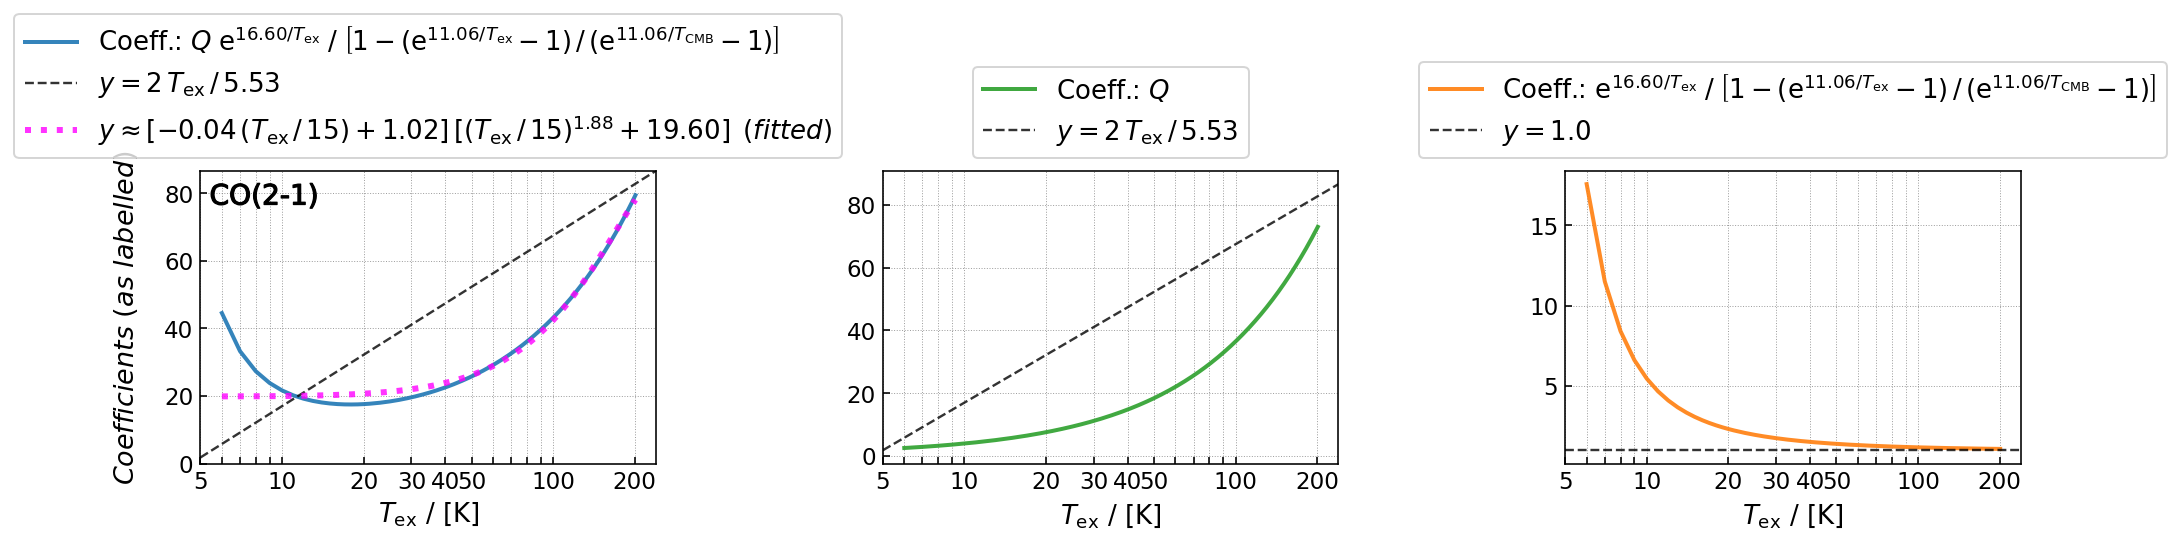

In [10]:
# CO21

if __name__ == '__main__' and '__file__' not in globals():
    
    #z = 0. # 4.
    nu = CO['nu'][1] * u.GHz # 2-1 is the second transition
    A_ul = CO['Einstein_A'][1] * u.s**(-1) # 2-1 is the second transition
    j_u = 2 # 2-1
    g_u = 2*j_u + 1
    T_CMB = 2.73 * (1.0 + z) * u.K
    E_1 = CO['E_u'][0] # always 1-0 upper level 

    print('T_CMB', T_CMB)

    # 8 pi kB nu^2 / ( h c^3 )
    coe1 = 8 * np.pi * const.k_B.cgs * nu.cgs**2 / (const.h.cgs * const.c.cgs**3)
    print('coe1', coe1)

    # 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul
    coe2 = coe1 / g_u / A_ul
    print('coe2', coe2)

    # 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul [M_sun pc-2 (K km s-1)-1]
    coe3 = (coe2 * (const.m_p + const.m_e).cgs*2).to(u.M_sun * u.pc**(-2) * u.K**(-1) * u.km**(-1) * u.s)
    print('coe3', coe3)

    # [X/H2]^{-1} * 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul * 100 [M_sun pc-2 (K km s-1)-1]
    coe4 = coe3 / 1e-4
    print('coe4', coe4)
    print('alphaCO21 function coefficients')

    # 
    list_of_T_kin = copy.copy(global_list_of_T_kin)
    if np.count_nonzero(list_of_T_kin < T_CMB) > 0:
        list_of_T_kin = list_of_T_kin[list_of_T_kin>T_CMB]
    #Q = np.array([ calc_Q(CO['E_u'], T_kin.value) for T_kin in list_of_T_kin ])

    top_left_text = 'CO(2-1)'
    out_fig_name = 'Plot_LTE_alpha_CO21'
    fig, QE_popt = make_a_plot_for_Q_E_term_vs_T_kin(list_of_T_kin, Ju=2, z=z, species='CO', 
                                                     top_left_text=top_left_text, 
                                                     out_fig_name=out_fig_name, 
                                                     return_popt=True)

    CO21_C_coeff = coe4
    CO21_QE_popt = QE_popt


T_CMB 2.73 K
coe1 4707.808412686791 1 / (cm3 K)
coe2 19914587194.10656 s / (cm3 K)
coe3 3.19176368328768e-05 s solMass / (K km pc2)
coe4 0.319176368328768 s solMass / (K km pc2)
alphaCI10 function coefficients
QE_CI10 mean: 7.113089858202337 over T_kin = 20 - 100 K
QE_CI function coefficients: [ 0.03286472  1.40989181 -3.83753049  4.59353046]
max diff positive x, y, yfit, (y-yfit)/y : 12.0 K , 10.366336072591059 , 9.978619560626898 , 0.03740149935803225
max diff negative x, y, yfit, (y-yfit)/y : 28.0 K , 6.575027623887606 , 6.892291007815849 , -0.048252783421867174
Output to "Plot_LTE_alpha_CI10.pdf"


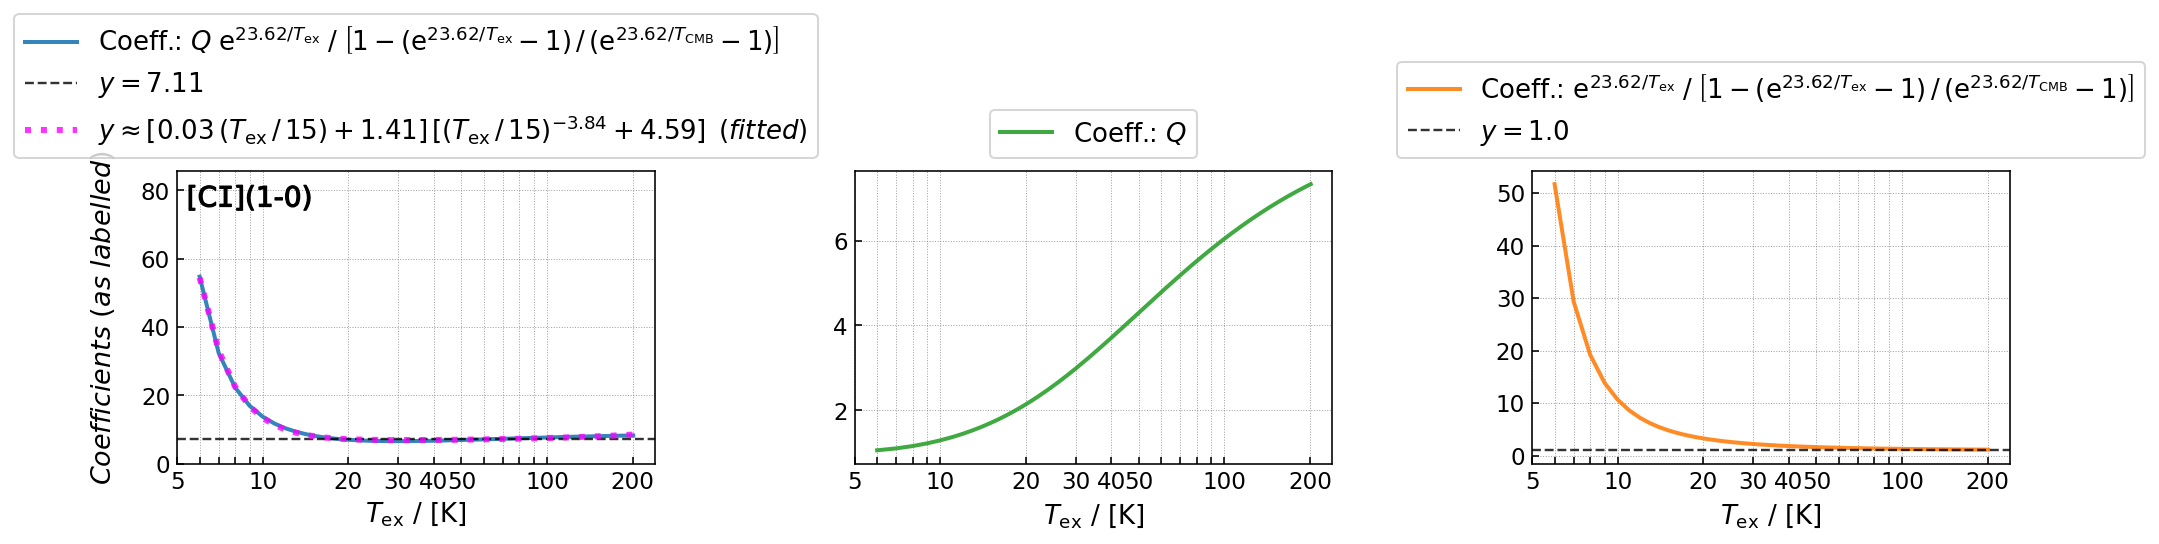

In [11]:
# CI10

if __name__ == '__main__' and '__file__' not in globals():
    
    #z = 0. # 4.
    nu = CI['nu'][0] * u.GHz # 1-0 is the first transition
    A_ul = CI['Einstein_A'][0] * u.s**(-1) # 1-0 is the first transition
    j_u = 1 # 1-0
    g_u = 2*j_u + 1
    T_CMB = 2.73 * (1.0 + z) * u.K
    E_1 = CI['E_u'][0] # always 1-0 upper level 

    print('T_CMB', T_CMB)

    # 8 pi kB nu^2 / ( h c^3 )
    coe1 = 8 * np.pi * const.k_B.cgs * nu.cgs**2 / (const.h.cgs * const.c.cgs**3)
    print('coe1', coe1)

    # 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul
    coe2 = coe1 / g_u / A_ul
    print('coe2', coe2)

    # 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul [M_sun pc-2 (K km s-1)-1]
    coe3 = (coe2 * (const.m_p + const.m_e).cgs*2).to(u.M_sun * u.pc**(-2) * u.K**(-1) * u.km**(-1) * u.s)
    print('coe3', coe3)

    # [X/H2]^{-1} * 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul [M_sun pc-2 (K km s-1)-1]
    coe4 = coe3 / 1e-4
    print('coe4', coe4)
    print('alphaCI10 function coefficients')

    # 
    list_of_T_kin = copy.copy(global_list_of_T_kin)
    if np.count_nonzero(list_of_T_kin < T_CMB) > 0:
        list_of_T_kin = list_of_T_kin[list_of_T_kin>T_CMB]
    #Q = np.array([ calc_Q(CI['E_u'], T_kin.value) for T_kin in list_of_T_kin ])

    top_left_text = r'[C$\tt{I}$](1-0)'
    out_fig_name = 'Plot_LTE_alpha_CI10'
    fig, QE_popt = make_a_plot_for_Q_E_term_vs_T_kin(list_of_T_kin, Ju=1, z=z, species='CI', 
                                                     top_left_text=top_left_text, 
                                                     out_fig_name=out_fig_name, 
                                                     return_popt=True)

    CI10_C_coeff = coe4
    CI10_QE_popt = QE_popt


T_CMB 2.73 K
coe1 12731.193778019833 1 / (cm3 K)
coe2 9608448134.354591 s / (cm3 K)
coe3 1.5399714545457403e-05 s solMass / (K km pc2)
coe4 0.15399714545457402 s solMass / (K km pc2)
alphaCI21 function coefficients
QE_CI10 mean: 29.964255263315955 over T_kin = 20 - 100 K
QE_CI function coefficients: [-0.73415465  8.46742857 -9.12820647  6.77320444]
max diff positive x, y, yfit, (y-yfit)/y : 201.0 K , 10.003993486195428 , -9.280941026961381 , 1.9277236175501522
max diff negative x, y, yfit, (y-yfit)/y : 58.0 K , 13.796557776467697 , 38.12434174178384 , -1.7633227330668801
Output to "Plot_LTE_alpha_CI21.pdf"


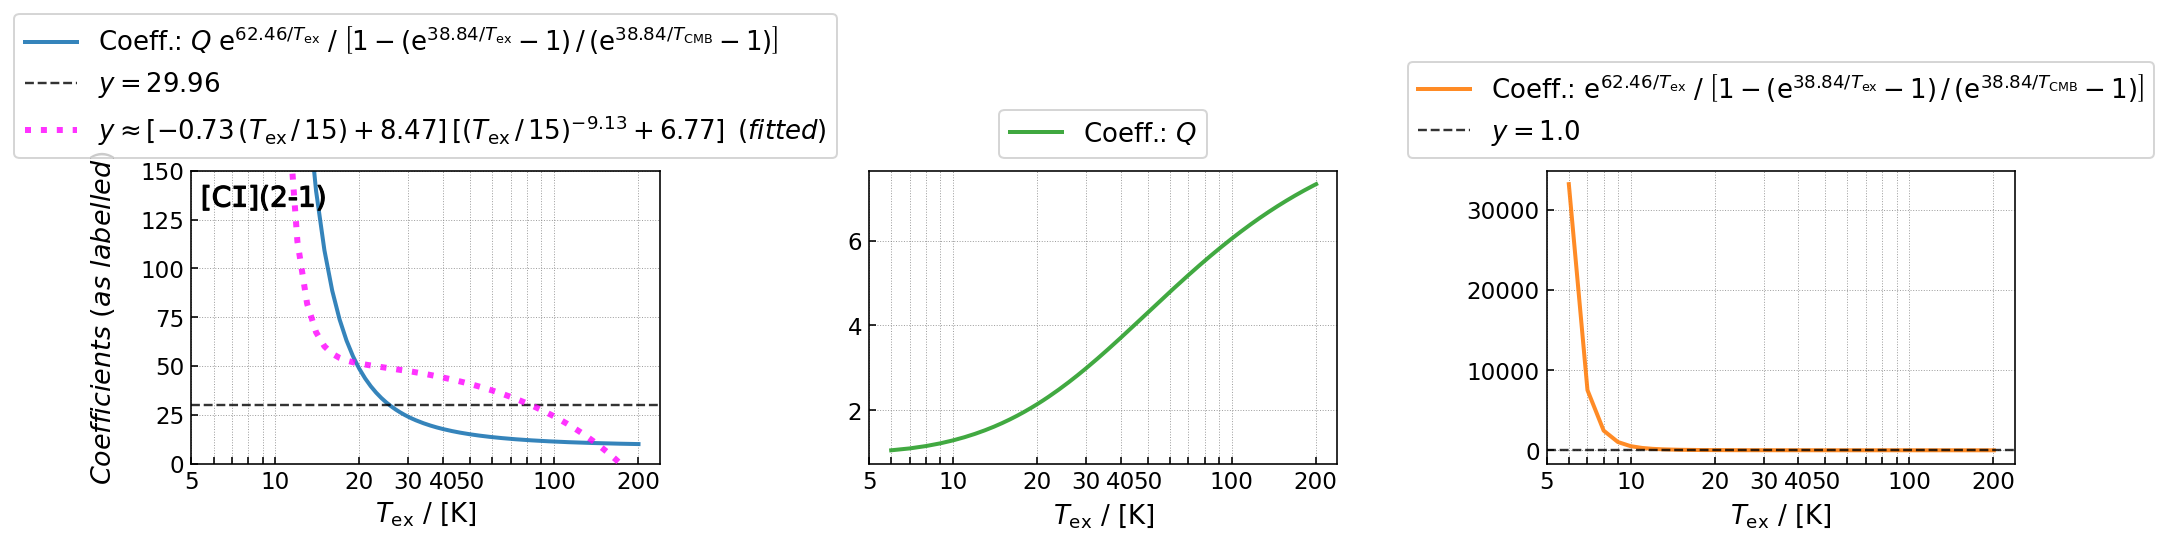

In [12]:
# CI21

if __name__ == '__main__' and '__file__' not in globals():
    
    #z = 0. # 4.
    nu = CI['nu'][1] * u.GHz # 2-1 is the second transition
    A_ul = CI['Einstein_A'][1] * u.s**(-1) # 2-1 is the second transition
    j_u = 2 # 2-1
    g_u = 2*j_u + 1
    T_CMB = 2.73 * (1.0 + z) * u.K
    E_1 = CI['E_u'][0] # always 1-0 upper level 

    print('T_CMB', T_CMB)

    # 8 pi kB nu^2 / ( h c^3 )
    coe1 = 8 * np.pi * const.k_B.cgs * nu.cgs**2 / (const.h.cgs * const.c.cgs**3)
    print('coe1', coe1)

    # 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul
    coe2 = coe1 / g_u / A_ul
    print('coe2', coe2)

    # 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul [M_sun pc-2 (K km s-1)-1]
    coe3 = (coe2 * (const.m_p + const.m_e).cgs*2).to(u.M_sun * u.pc**(-2) * u.K**(-1) * u.km**(-1) * u.s)
    print('coe3', coe3)

    # [X/H2]^{-1} * 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul [M_sun pc-2 (K km s-1)-1]
    coe4 = coe3 / 1e-4
    print('coe4', coe4)
    print('alphaCI21 function coefficients')

    # 
    list_of_T_kin = copy.copy(global_list_of_T_kin)
    if np.count_nonzero(list_of_T_kin < T_CMB) > 0:
        list_of_T_kin = list_of_T_kin[list_of_T_kin>T_CMB]
    #Q = np.array([ calc_Q(CI['E_u'], T_kin.value) for T_kin in list_of_T_kin ])
    
    top_left_text = r'[C$\tt{I}$](2-1)'
    out_fig_name = 'Plot_LTE_alpha_CI21'
    fig, QE_popt = make_a_plot_for_Q_E_term_vs_T_kin(list_of_T_kin, Ju=2, z=z, species='CI', 
                                                     top_left_text=top_left_text, 
                                                     out_fig_name=out_fig_name, 
                                                     return_popt=True)

    CI21_C_coeff = coe4
    CI21_QE_popt = QE_popt


In [13]:
# Store into json file

json_file = 'out_LTE_alphaCO_alphaCI_new_QE_term_popt.json'
if z > 0:
    json_file = json_file.replace('.json', '_z{:g}.json'.format(z))

if __name__ == '__main__' and '__file__' not in globals():
    
    json_data = OrderedDict()
    json_data['CO10_C_coeff'] = (CO10_C_coeff.value, str(CO10_C_coeff.unit))
    json_data['CO10_QE_popt'] = CO10_QE_popt.tolist()
    json_data['CO21_C_coeff'] = (CO21_C_coeff.value, str(CO21_C_coeff.unit))
    json_data['CO21_QE_popt'] = CO21_QE_popt.tolist()
    json_data['CI10_C_coeff'] = (CI10_C_coeff.value, str(CI10_C_coeff.unit))
    json_data['CI10_QE_popt'] = CI10_QE_popt.tolist()
    json_data['CI21_C_coeff'] = (CI21_C_coeff.value, str(CI21_C_coeff.unit))
    json_data['CI21_QE_popt'] = CI21_QE_popt.tolist()
    #print('json_data', json_data)
    if os.path.isfile(json_file):
        shutil.move(json_file, json_file + '.backup')
    with open(json_file, 'w') as fp:
        json.dump(json_data, fp, indent=4)
    print('Output to {!r}'.format(json_file))

else:
    
    print('Loading {!r}'.format(json_file))
    with open(json_file, 'r') as fp:
        json_data = json.load(fp)
        CO10_C_coeff = u.Quantity(json_data['CO10_C_coeff'][0], unit = json_data['CO10_C_coeff'][1])
        CO10_QE_popt = json_data['CO10_QE_popt']
        CO21_C_coeff = u.Quantity(json_data['CO21_C_coeff'][0], unit = json_data['CO21_C_coeff'][1])
        CO21_QE_popt = json_data['CO21_QE_popt']
        CI10_C_coeff = u.Quantity(json_data['CI10_C_coeff'][0], unit = json_data['CI10_C_coeff'][1])
        CI10_QE_popt = json_data['CI10_QE_popt']
        CI21_C_coeff = u.Quantity(json_data['CI21_C_coeff'][0], unit = json_data['CI21_C_coeff'][1])
        CI21_QE_popt = json_data['CI21_QE_popt']

print('CO10_C_coeff', '=', CO10_C_coeff.value, '#', CO10_C_coeff.unit)
print('CO10_QE_popt', '=', list2str(CO10_QE_popt))
print('CO21_C_coeff', '=', CO21_C_coeff.value, '#', CO21_C_coeff.unit)
print('CO21_QE_popt', '=', list2str(CO21_QE_popt))
print('CI10_C_coeff', '=', CI10_C_coeff.value, '#', CI10_C_coeff.unit)
print('CI10_QE_popt', '=', list2str(CI10_QE_popt))
print('CI21_C_coeff', '=', CI21_C_coeff.value, '#', CI21_C_coeff.unit)
print('CI21_QE_popt', '=', list2str(CI21_QE_popt))


Output to 'out_LTE_alphaCO_alphaCI_new_QE_term_popt.json'
CO10_C_coeff = 0.019154525467252038 # s solMass / (K km pc2)
CO10_QE_popt = [1.1855213097182806, 1.0508769810006267, 0.13519638277088097, 3.0422437165805363]
CO21_C_coeff = 0.004791830144641124 # s solMass / (K km pc2)
CO21_QE_popt = [-0.03806215000201428, 1.0208884666182112, 1.8849023333493993, 19.602163682391556]
CI10_C_coeff = 0.319176368328768 # s solMass / (K km pc2)
CI10_QE_popt = [0.03286472230426837, 1.40989181037848, -3.8375304873755893, 4.593530462560491]
CI21_C_coeff = 0.15399714545457402 # s solMass / (K km pc2)
CI21_QE_popt = [-0.7341546505417581, 8.46742857101429, -9.128206472756512, 6.773204440686132]


### Define function to fit the tau term

In [14]:
# define function to fit the alpha_Xul

def func_alpha_T_only_approx(T_ex, a, b, c, d):
    return (a + (T_ex/75.0)**b) * ((T_ex/75.0)**c) + d

def latex_str_func_alpha_T_only_approx(a, b, c, d):
    str_format = '[ ({:.2f} + (T_ex/75)^{{{:.2f}}}) \\cdot (T_ex/75)^{{{:.2f}}} {:+.2f} ]'
    latex_str = str_format.format(a, b, c, d)
    latex_str = latex_str.replace('T_ex', r'T_{\mathrm{ex}}')
    latex_str = latex_str.replace('*', r'\,')
    latex_str = latex_str.replace('/', r'\,/\,')
    return latex_str

def lambda_str_func_alpha_T_only_approx(a, b, c, d):
    str_format = 'lambda T_ex: ( ({:g} + (T_ex/75)**({:g})) * (T_ex/75)**({:g}) ) {:+g}'
    lambda_str = str_format.format(a, b, c, d)
    return lambda_str

func_alpha_CO = func_alpha_T_only_approx
func_alpha_CI = func_alpha_T_only_approx
latex_str_func_alpha_CO = latex_str_func_alpha_T_only_approx
latex_str_func_alpha_CI = latex_str_func_alpha_T_only_approx
lambda_str_func_alpha_CO = lambda_str_func_alpha_T_only_approx
lambda_str_func_alpha_CI = lambda_str_func_alpha_T_only_approx

def fit_func_alpha_CO(x, y):
    popt, pcov = curve_fit(func_alpha_CO, x, y, p0=[0.2, 2.4, -1.2, 0.0])
    yfit = func_alpha_CO(x, *popt)
    return popt, yfit

def fit_func_alpha_CI(x, y):
    popt, pcov = curve_fit(func_alpha_CI, x, y, p0=[0.01, 2.4, -1.2, 0.0]) # same as CO except for p0
    yfit = func_alpha_CI(x, *popt)
    return popt, yfit

def fit_func_alpha_CI_z2(x, y):
    popt, pcov = curve_fit(func_alpha_CI, x, y, p0=[0.01, 4.4, -5.2, 6.0]) # same as CO except for p0
    yfit = func_alpha_CI(x, *popt)
    return popt, yfit

# CO and CI have the same functional form


### Define function to plot the tau term

In [15]:
# define function to plot one set of Q*ehnukt*Bnuratio vs. T_kin

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 11.5
matplotlib.rcParams['ytick.labelsize'] = 11.5
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['axes.formatter.useoffset'] = False
#matplotlib.rcParams['mathtext.fontset'] = 'custom'
#matplotlib.rcParams['mathtext.cal'] = 'stix:italic'
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker
import matplotlib.patheffects as path_effects

def make_a_plot_for_tau_term_vs_T_kin(
        list_of_T_kin=None, 
        z=0.0, 
        species='CO', 
        transition=0, 
        j_u=1, 
        d_V=None, 
        species_to_H2_conversion=None,
        top_left_text=None, 
        first_panel_text=None,
        first_panel_approx=None, 
        first_panel_function=None, 
        second_panel_approx=None, 
        second_panel_function=None, 
        third_panel_approx=None, 
        third_panel_function=None, 
        out_fig_name=None, 
        return_popt=False, 
    ):
    
    global list_of_T_kin_for_N_repISM
    global list_of_N_CO_for_N_repISM
    global list_of_N_CI_for_N_repISM
    global list_of_d_V_for_N_repISM
    global list_of_Sigma_H2_for_N_repISM
    global list_of_linestyle_for_N_repISM
    global list_of_linecolor_for_N_repISM
    global list_of_linelabel_for_N_repISM
    global list_of_linethick_for_N_repISM
    global X_CO_H2
    global X_CI_CO
    
    T_CMB = 2.73 * (1.0 + z) # u.K
    
    # check input xgrid
    if list_of_T_kin is None:
        list_of_T_kin = (copy.copy(global_list_of_T_kin)).value
    if np.count_nonzero(list_of_T_kin < T_CMB) > 0:
        list_of_T_kin = list_of_T_kin[list_of_T_kin>T_CMB]
    
    if species == 'CO':
        list_of_N_species_for_N_repISM = list_of_N_CO_for_N_repISM
        global CO
        species_moldata = CO
    elif species == 'CI':
        list_of_N_species_for_N_repISM = list_of_N_CI_for_N_repISM
        global CI
        species_moldata = CI
    else:
        list_of_N_species_for_N_repISM = None
        raise Exception('Error! The input species must be either "CO" or "CI"!')
    
    print('list_of_N_species_for_N_repISM', list_of_N_species_for_N_repISM)
    print('list_of_Sigma_H2_for_N_repISM', list_of_Sigma_H2_for_N_repISM)
    print('list_of_d_V_for_N_repISM', list_of_d_V_for_N_repISM)
    
    # fix to user input d_V
    #if d_V is not None:
    #    if np.isscalar(d_V):
    #        list_of_d_V = [d_V]*len(list_of_d_V_for_N_repISM)
    #    else:
    #        list_of_d_V = d_V
    #    print('list_of_d_V', list_of_d_V)
    
    # calculate tau for each representative ISM (repISM)
    list_of_tau_for_N_repISM = []
    for idx_N_repISM, N_species in enumerate(list_of_N_species_for_N_repISM):
        N_species = float(N_species)
        N_species_str = re.sub(r'e\+(0+|)', r'e', '%.1e'%(N_species))
        #print('N_species', N_species)
        d_V = list_of_d_V_for_N_repISM[idx_N_repISM]
        d_V_str = '%.1f'%(d_V)
        #print('d_V', d_V)
        N_dV = N_species / d_V
        #print('N_dV', N_dV)
        list_of_tau = np.array([
            calc_tau(
                nu = species_moldata['nu'][transition], 
                g_u = 2*j_u+1, 
                E_u = species_moldata['E_u'][transition],
                Q = calc_Q(species_moldata['E_u'], T_ex), 
                A_ul = species_moldata['Einstein_A'][transition],
                N_dV = N_dV, 
                T_ex = T_ex, 
            ) for T_ex in list_of_T_kin 
        ])
        # 
        list_of_tau_for_N_repISM.append(copy.copy(list_of_tau))
    
    # plot tau 
    fig = plt.figure(figsize=(17,4.8))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
    x = np.array(list_of_T_kin)
    ally1 = []
    for idx_N_repISM, N_species in enumerate(list_of_N_species_for_N_repISM):
        N_species = float(N_species)
        N_species_str = re.sub(r'e\+(0+|)', r'e', '%.1e'%(N_species))
        d_V = list_of_d_V_for_N_repISM[idx_N_repISM]
        d_V_str = '%.1f'%(d_V)
        N_d_V = N_species / d_V
        N_d_V_str = re.sub(r'e\+(0+|)', r'e', '%.1e'%(N_d_V))
        list_of_tau = list_of_tau_for_N_repISM[idx_N_repISM]
        linestyle = list_of_linestyle_for_N_repISM[idx_N_repISM]
        linethick = list_of_linethick_for_N_repISM[idx_N_repISM]
        linecolor = list_of_linecolor_for_N_repISM[idx_N_repISM]
        linelabel = list_of_linelabel_for_N_repISM[idx_N_repISM]
        Sigma_H2 = list_of_Sigma_H2_for_N_repISM[idx_N_repISM]
        Sigma_H2_str = '%.0f'%(Sigma_H2)
        Sigma_mol_str = '%.0f'%(Sigma_H2*1.36)
        if linelabel is None or linelabel == '':
            linelabel = r'$N_{\mathrm{%s}}$=%s'%(species, N_species_str) + \
                        r', $\Sigma_{\mathrm{mol}}$=%s'%(Sigma_mol_str) + \
                        r', $\Delta v$=%g'%(d_V) + \
                        '\n' + r'$N_{\mathrm{%s}}/{\Delta v} = %s$'%(species, N_d_V_str)
        if isinstance(linestyle, dict):
            linestyle = [linestyle[t] for t in linestyle][0]
        y1 = species_to_H2_conversion(list_of_T_kin, list_of_tau)
        y2 = list_of_tau
        y3 = list_of_tau / (1.0 - np.exp(-list_of_tau))
        ally1.append(y1)
        ax1.plot(x, 
                 y1, 
                 ls=linestyle, 
                 lw=linethick, 
                 color=linecolor, 
                 label=linelabel, 
                )
        ax2.plot(x, 
                 y2, 
                 ls=linestyle, 
                 lw=linethick, 
                 color=linecolor, 
                 label=linelabel, 
                )
        ax3.plot(x, 
                 y3, 
                 ls=linestyle, 
                 lw=linethick, 
                 color=linecolor, 
                 label=linelabel, 
                )

    # get mean y1
    meany1 = np.mean(ally1, axis=0)
    
    # 20220326 - use y1[0] about NCO/dV = 2e17
    meany1 = ally1[0]
    
    # curve_fit
    if species == 'CO':
        popt, fity1 = fit_func_alpha_CO(x, meany1)
        popt_print_str = 'popt = ' + list2str(popt)
        popt_lambda_str = lambda_str_func_alpha_CO(*popt)
    elif species == 'CI':
        if z > 1:
            popt, fity1 = fit_func_alpha_CI_z2(x, meany1)
        else:
            popt, fity1 = fit_func_alpha_CI(x, meany1)
        popt_print_str = 'popt = ' + list2str(popt)
        popt_lambda_str = lambda_str_func_alpha_CI(*popt)
    else:
        popt = None
        raise NotImplementedError('species must be either CO or CI!')
    print('alpha'+species+str(transition+1)+str(transition) + \
          ' ' + popt_print_str)
    print('alpha'+species+str(transition+1)+str(transition) + \
          ' = ' + popt_lambda_str)
    
    # Panel 1
    ax1.set_xlabel(r'$T_{\mathrm{ex}} \ / \ [\mathrm{K}]$', fontsize=13)
    ax1.set_ylabel(r'$Coefficients \ (as \ labelled)$', fontsize=13.5)
    ax1.set_yscale('log')
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax1.yaxis.set_minor_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8), ))
    ax1.yaxis.set_minor_formatter(ticker.FormatStrFormatter('%g'))
    set_xticks_log(ax1)
    
    if species == 'CO':
        panel1_label = first_panel_text + '\n' + r'$\approx \ ' + latex_str_func_alpha_CO(*popt) + '$'
        t_exp = int(np.floor(np.log10(X_CO_H2)))
        t_val = (X_CO_H2) / 10**t_exp
        str_abun = r'[\mathrm{CO/H_2}]'
    elif species == 'CI':
        panel1_label = first_panel_text + '\n' + r'$\approx \ ' + latex_str_func_alpha_CI(*popt) + '$'
        t_exp = int(np.floor(np.log10(X_CO_H2 * X_CI_CO)))
        t_val = (X_CO_H2 * X_CI_CO) / 10**t_exp
        str_abun = r'[\mathrm{C}_{\tt{I}}/\mathrm{H_2}]'
    str_val = '{:g}'.format(t_val)
    str_exp = '{:d}'.format(t_exp)
    panel1_label += ('\n' + r'   $ \times \; (' + str_val + \
                     r' \times 10^{' + str_exp + r'} \;/\; ' + str_abun + r')$')
    tt1 = ax1.text(0.5, 1.03, 
                   panel1_label, 
                   ha='center', va='bottom', transform=ax1.transAxes, fontsize=15)
    tt1.set_bbox(dict(facecolor='white', alpha=0.3, edgecolor='#666666'))

    # Panel 2
    ax2.set_xlabel(r'$T_{\mathrm{ex}} \ / \ [\mathrm{K}]$', fontsize=13)
    ax2.set_yscale('log')
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    set_xticks_log(ax2)
    
    panel2_label = 'Coeff.: ' + r'$\tau_{\mathrm{%s}(%d{\tt{-}}%d)}$'%(species, j_u, j_u-1)
    tt2 = ax2.text(0.5, 1.03, 
                   panel2_label, 
                   ha='center', va='bottom', transform=ax2.transAxes, fontsize=15)
    tt2.set_bbox(dict(facecolor='white', alpha=0.3, edgecolor='#666666'))
    
    # Panel 3
    ax3.set_xlabel(r'$T_{\mathrm{ex}} \ / \ [\mathrm{K}]$', fontsize=13)
    ax3.set_yscale('log')
    ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax3.yaxis.set_minor_formatter(ticker.FormatStrFormatter('%g'))
    if np.log10(ax3.get_ylim()[1]/ax3.get_ylim()[0]) > 1:
        ax3.yaxis.set_minor_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.3, 0.4, 0.5), ))
    set_xticks_log(ax3)
    
    panel3_label = 'Coeff.: ' + \
                   r'$\tau_{\mathrm{%s}(%d{\tt{-}}%d)} \; / \; '%(species, j_u, j_u-1) + \
                   r'(1 - \mathrm{e}^{ - \tau_{\mathrm{%s}(%d{\tt{-}}%d)} })$'%(species, j_u, j_u-1)
    tt3 = ax3.text(0.5, 1.03, panel3_label, 
                   ha='center', va='bottom', transform=ax3.transAxes, fontsize=15)
    tt3.set_bbox(dict(facecolor='white', alpha=0.3, edgecolor='#666666'))

    # fix ax1 x axis range
    ax1.set_xlim(ax1.get_xlim())
    
    # show canonical alphaCO in panel 1
    if species == 'CO' and transition == 0:
        highlight_y = 4.35/1.36 # Bolatto+2013 ARA&A, 1./1.36 removes the Helium
        highlight_color = 'blue'
        highlight_fill = ax1.fill_between(ax1.get_xlim(), 
                                          [highlight_y/1.2]*2, 
                                          [highlight_y*1.2]*2, 
                                          lw=0.0, alpha=0.3, color=highlight_color)
        highlight_tt = ax1.text(
            ax1.get_xlim()[1]-0.04*(ax1.get_xlim()[1]-ax1.get_xlim()[0]), 
            highlight_y, 
            '"Galactic"', ha='right', va='center', color=highlight_color, fontsize=13)
        highlight_tt.set_path_effects(
            [path_effects.Stroke(linewidth=0.3, foreground='k'), path_effects.Normal()])
        # 
        highlight_y = 0.6 # Papadopoulos+2012 ApJ # or ULIRG 0.8/1.36 # 
        highlight_color = 'red'
        highlight_fill = ax1.fill_between(ax1.get_xlim(), 
                                          [highlight_y/1.1]*2, 
                                          [highlight_y*1.1]*2, 
                                          lw=0.0, alpha=0.3, color=highlight_color)
        highlight_tt = ax1.text(
            ax1.get_xlim()[1]-0.04*(ax1.get_xlim()[1]-ax1.get_xlim()[0]), 
            highlight_y, 
            '"Starburst"', ha='right', va='center', color=highlight_color, fontsize=13)
        highlight_tt.set_path_effects(
            [path_effects.Stroke(linewidth=0.3, foreground='k'), path_effects.Normal()])
        # 
        ax1.annotate('', xy=(15.0, 3.2), xytext=(15.0, 0.8), xycoords='data', textcoords='data', va='top', 
                     arrowprops=dict(facecolor='blue', edgecolor='none', shrink=0.05, width=1.5, 
                                     headwidth=10., alpha=0.8),
                    )

    # fix ax1 x axis range
    ax1.set_xlim(ax1.get_xlim())
    ax1.set_ylim(ax1.get_ylim())
    ax2.set_xlim(ax2.get_xlim())
    ax2.set_ylim(ax2.get_ylim())
    ax3.set_xlim(ax3.get_xlim())
    ax3.set_ylim(ax3.get_ylim())
    
    # adjust CI panel 1 ylim manually
    #if species == 'CI':
    #    ax1.set_ylim([ax1.get_ylim()[0]/1.2, ax1.get_ylim()[1]*1.2])
    #    #ax1.set_ylim([2.9, 30.1])
    #    #ax1.set_yticks([3, 4, 5, 6, 7, 8, 9])
    #    #ax1.yaxis.set_major_locator(ticker.LogLocator(base=1, numdecs=15))
    
    # overlay function in panels
    overlay_x = x
    overlay_y = fity1
    overlay_dex = 0.2
    ax1.plot(overlay_x, overlay_y, 
                     color='darkgray', alpha=0.4, ls='dotted', lw=2)
    ax1.fill_between(overlay_x, overlay_y/(10**overlay_dex), overlay_y*(10**overlay_dex), 
                     color='darkgray', alpha=0.2, ls='dotted', lw=0) # +- overlay_dex dex
    
    # show legend in panel 3
    ax3.legend(fontsize=12, loc='center left', bbox_to_anchor=(1.0, 0.1, 0.5, 0.8))

    # show top left text and set out fig name
    if z > 0.0:
        top_left_text = top_left_text + r' $z = {:g}$'.format(z)
    tt1 = ax1.text(0.50, 0.96, top_left_text, ha='center', va='top', transform=ax1.transAxes, fontsize=14)
    tt1.set_path_effects([path_effects.Stroke(linewidth=0.6, foreground='black'), path_effects.Normal()])

    fig.tight_layout()
    
    if out_fig_name is not None:
        if z > 0.0:
            out_fig_name = copy.copy(out_fig_name)
            out_fig_name += '_z{:g}'.format(z)
        fig.savefig(out_fig_name+'.pdf', dpi=300)
        print('Output to "%s"'%(out_fig_name+'.pdf'))
    
    if return_popt:
        return fig, popt
    else:
        return fig


### Now we plot the alpha factor and tau term vs T_kin

list_of_N_species_for_N_repISM [6.42352941e+17 1.37647059e+18 1.83529412e+18 3.67058824e+18
 3.99618588e+18 4.29186133e+18 6.88235294e+18]
list_of_Sigma_H2_for_N_repISM [ 102.94117647  220.58823529  294.11764706  588.23529412  640.41440438
  687.79828981 1102.94117647]
list_of_d_V_for_N_repISM [3.0, 10.0, 25.0, 50.0, 40.0, 70.0, 90.0]
alphaCO10 popt = [0.22330488826229442, 2.3687705827381773, -1.789785525987841, -0.3396791065630381]
alphaCO10 = lambda T_ex: ( (0.223305 + (T_ex/75)**(2.36877)) * (T_ex/75)**(-1.78979) ) -0.339679
Output to "Plot_LTE_tau_CO10.pdf"


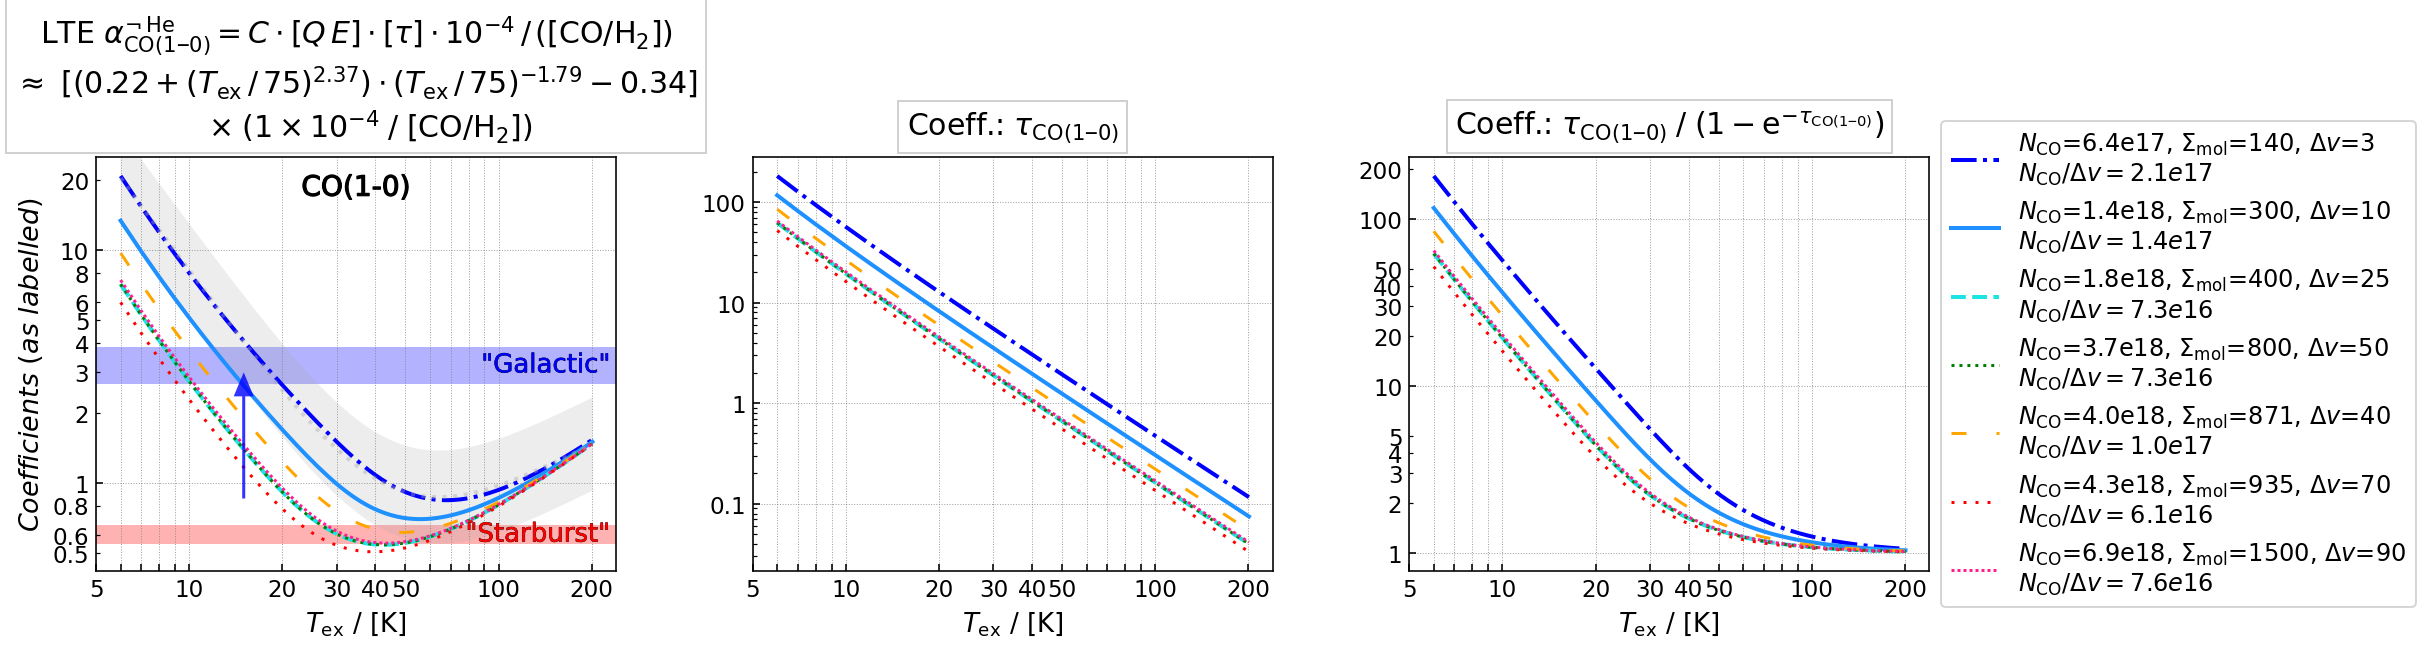

In [16]:
# tau CO10

CO10_to_H2_conversion = lambda tkin, tau: CO10_C_coeff.value * 1e-4 / X_CO_H2 \
                                          * func_QE_CO(tkin, *CO10_QE_popt) \
                                          * ( tau / (1.0 - np.exp(-tau)) )

if __name__ == '__main__' and '__file__' not in globals():

    #z = 0. # 0. 4. 10.

    top_left_text = 'CO(1-0)'

    out_fig_name = 'Plot_LTE_tau_CO10'

    first_panel_text = r'LTE $\alpha_{\mathrm{CO(1{\tt{-}}0)}}^{\neg\,\mathrm{He}} = $' + \
                       r'$C \cdot [Q\,E] \cdot [\tau] \cdot 10^{-4} \, / \, (\mathrm{[CO/H_2]})$'
                       # alphaCO10 function

    fig, popt = make_a_plot_for_tau_term_vs_T_kin(
            z=z, 
            species='CO', 
            transition=0, 
            j_u=1, 
            species_to_H2_conversion=CO10_to_H2_conversion, 
            first_panel_text=first_panel_text, 
            top_left_text=top_left_text, 
            out_fig_name=out_fig_name, 
            return_popt=True,
        )
    
    CO10_T_only_popt = popt


list_of_N_species_for_N_repISM [6.42352941e+17 1.37647059e+18 1.83529412e+18 3.67058824e+18
 3.99618588e+18 4.29186133e+18 6.88235294e+18]
list_of_Sigma_H2_for_N_repISM [ 102.94117647  220.58823529  294.11764706  588.23529412  640.41440438
  687.79828981 1102.94117647]
list_of_d_V_for_N_repISM [3.0, 10.0, 25.0, 50.0, 40.0, 70.0, 90.0]
alphaCO21 popt = [0.01086499093929999, 2.6531620827923987, -4.013124775978004, -0.18883247908141274]
alphaCO21 = lambda T_ex: ( (0.010865 + (T_ex/75)**(2.65316)) * (T_ex/75)**(-4.01312) ) -0.188832
Output to "Plot_LTE_tau_CO21.pdf"


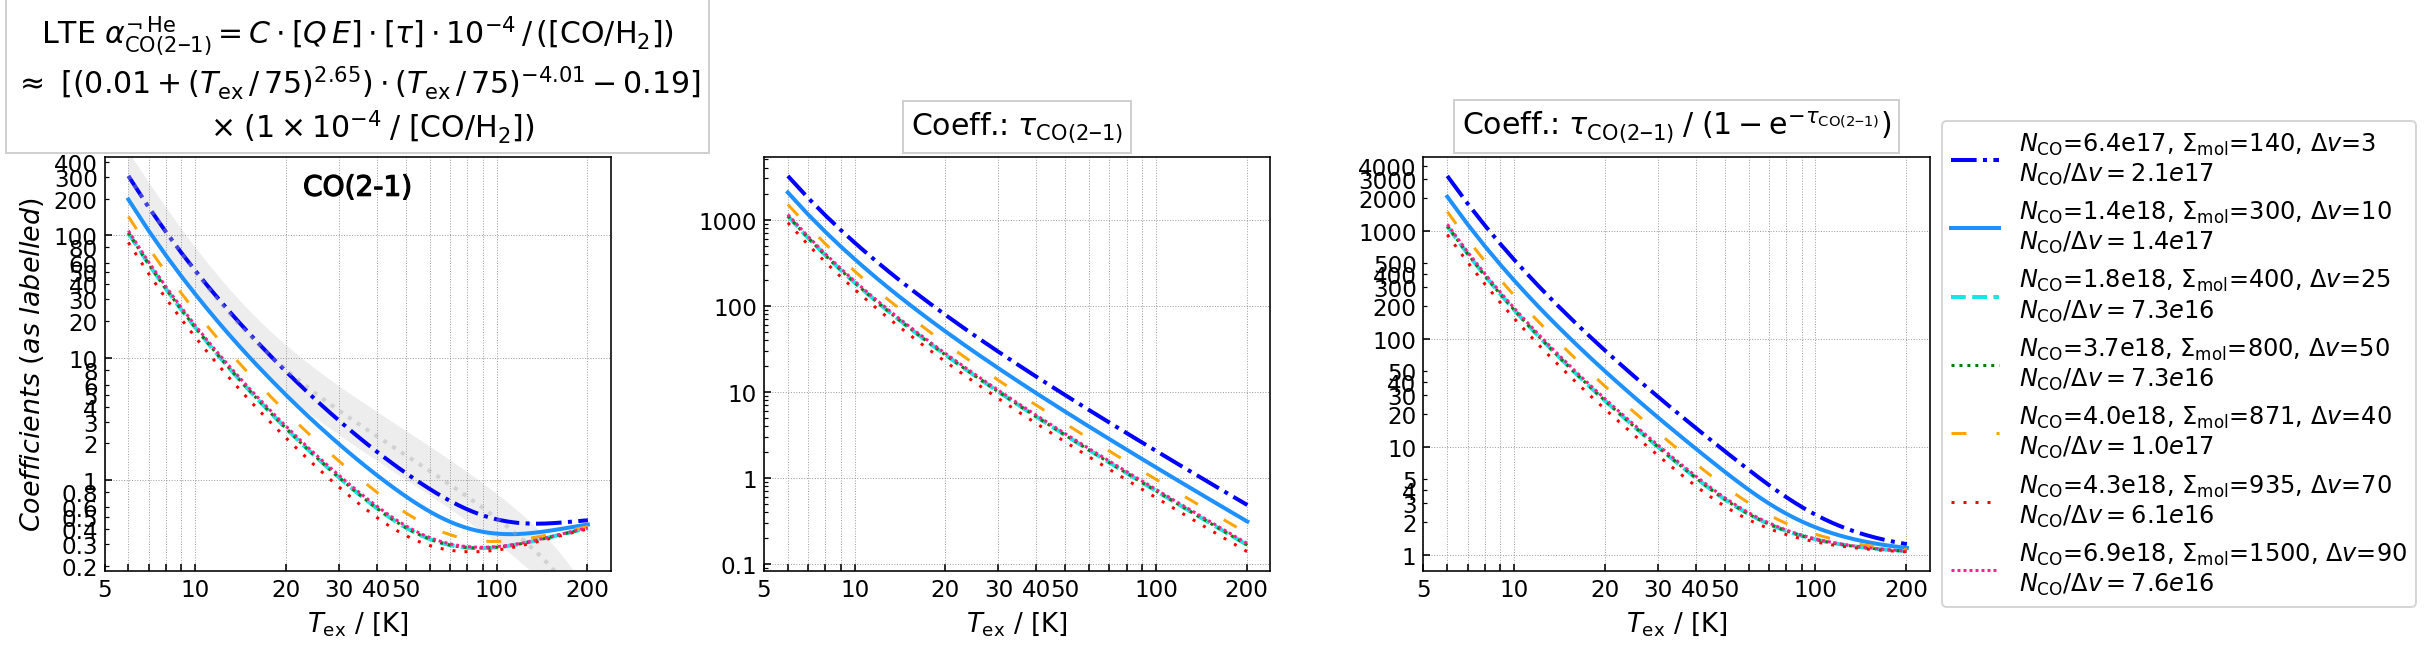

In [17]:
# tau CO21

CO21_to_H2_conversion = lambda tkin, tau: CO21_C_coeff.value * 1e-4 / X_CO_H2 \
                                          * func_QE_CO(tkin, *CO21_QE_popt) \
                                          * ( tau / (1.0 - np.exp(-tau)) )

if __name__ == '__main__' and '__file__' not in globals():

    #z = 0. # 0. 4. 10.

    top_left_text = 'CO(2-1)'

    out_fig_name = 'Plot_LTE_tau_CO21'

    first_panel_text = r'LTE $\alpha_{\mathrm{CO(2{\tt{-}}1)}}^{\neg\,\mathrm{He}} = $' + \
                       r'$C \cdot [Q\,E] \cdot [\tau] \cdot 10^{-4} \, / \, (\mathrm{[CO/H_2]})$'
                       # alphaCO21 function

    fig, popt = make_a_plot_for_tau_term_vs_T_kin(
            z=z, 
            species='CO', 
            transition=1, 
            j_u=2, 
            species_to_H2_conversion=CO21_to_H2_conversion, 
            first_panel_text=first_panel_text, 
            top_left_text=top_left_text, 
            out_fig_name=out_fig_name, 
            return_popt=True,
        )
    
    CO21_T_only_popt = popt


list_of_N_species_for_N_repISM [1.28470588e+17 2.75294118e+17 3.67058824e+17 7.34117647e+17
 7.99237177e+17 8.58372266e+17 1.37647059e+18]
list_of_Sigma_H2_for_N_repISM [ 102.94117647  220.58823529  294.11764706  588.23529412  640.41440438
  687.79828981 1102.94117647]
list_of_d_V_for_N_repISM [3.0, 10.0, 25.0, 50.0, 40.0, 70.0, 90.0]
alphaCI10 popt = [2.168885617086368e-05, 5.621883774867879, -7.471872416725909, 11.249645304617172]
alphaCI10 = lambda T_ex: ( (2.16889e-05 + (T_ex/75)**(5.62188)) * (T_ex/75)**(-7.47187) ) +11.2496
Output to "Plot_LTE_tau_CI10.pdf"


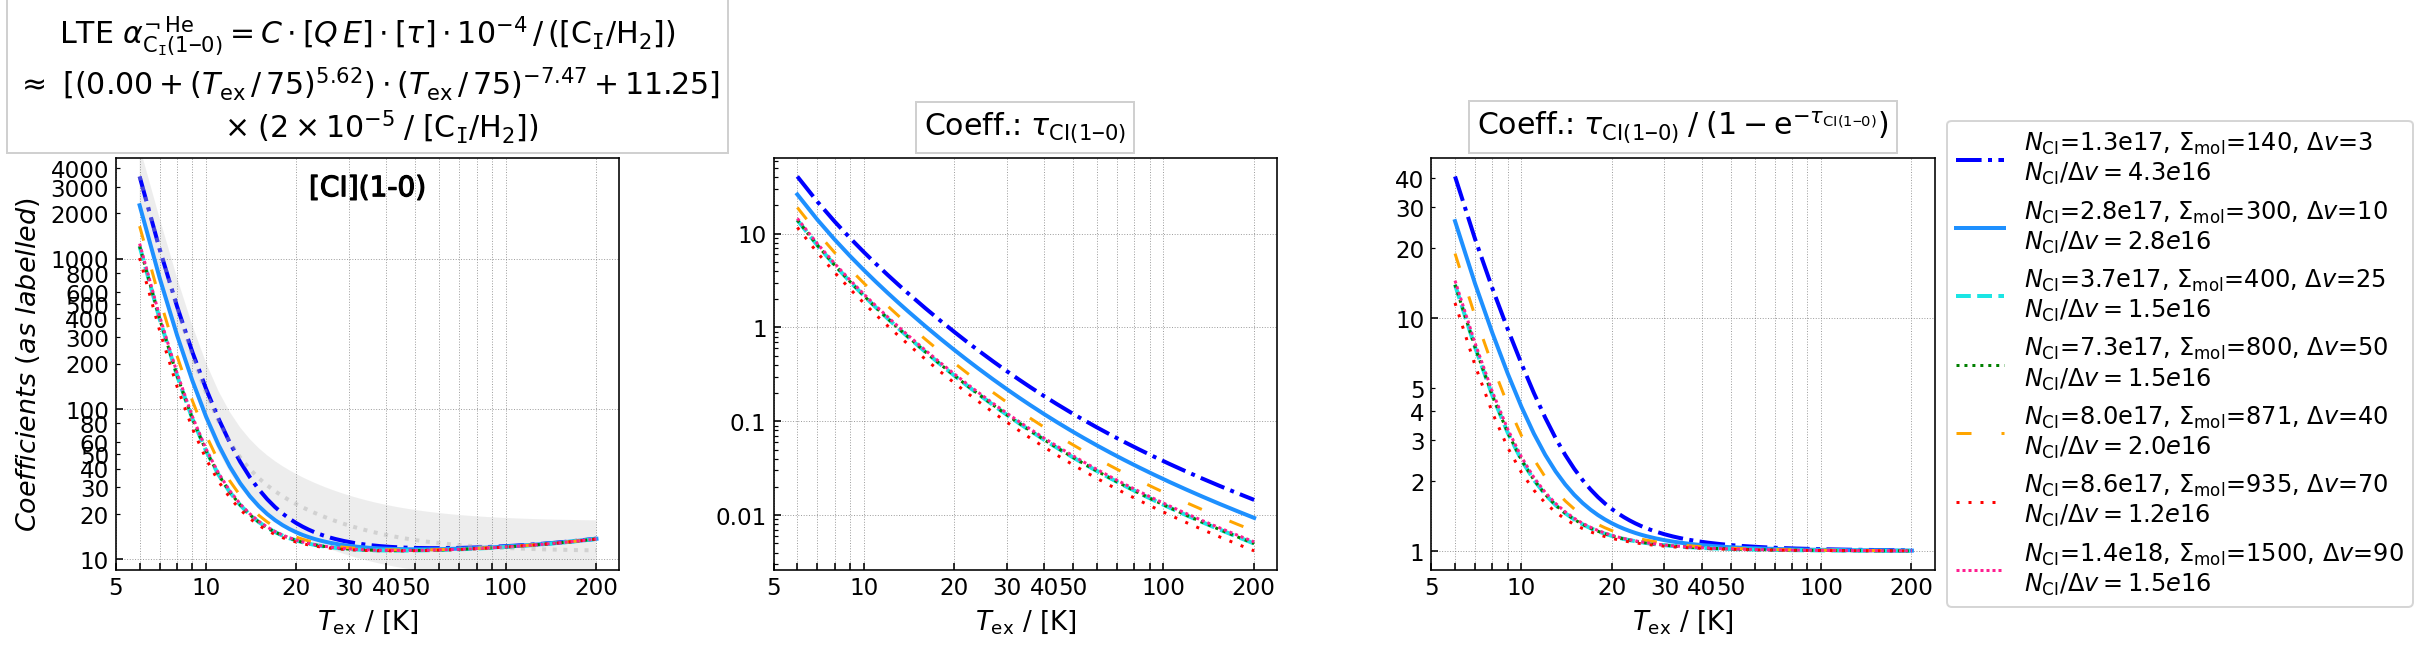

In [18]:
# tau CI10

CI10_to_H2_conversion = lambda tkin, tau: CI10_C_coeff.value * 1e-4 / (X_CO_H2 * X_CI_CO) \
                                          * func_QE_CI(tkin, *CI10_QE_popt) \
                                          * ( tau / (1.0 - np.exp(-tau)) )

if __name__ == '__main__' and '__file__' not in globals():

    #z = 0. # 0. 4. 10.

    top_left_text = '[CI](1-0)'

    out_fig_name = 'Plot_LTE_tau_CI10'

    first_panel_text = r'LTE $\alpha_{\mathrm{C}_{\tt{I}}(1{\tt{-}}0)}^{\neg\,\mathrm{He}} = $' + \
                       r'$C \cdot [Q\,E] \cdot [\tau] \cdot 10^{-4} \, / \, ([\mathrm{C}_{\tt{I}}/\mathrm{H_2}])$'
                       # alphaCI10 function

    fig, popt = make_a_plot_for_tau_term_vs_T_kin(
            z=z, 
            species='CI', 
            transition=0, 
            j_u=1, 
            species_to_H2_conversion=CI10_to_H2_conversion, 
            first_panel_text=first_panel_text, 
            top_left_text=top_left_text, 
            out_fig_name=out_fig_name, 
            return_popt=True,
        )
    
    CI10_T_only_popt = popt


list_of_N_species_for_N_repISM [1.28470588e+17 2.75294118e+17 3.67058824e+17 7.34117647e+17
 7.99237177e+17 8.58372266e+17 1.37647059e+18]
list_of_Sigma_H2_for_N_repISM [ 102.94117647  220.58823529  294.11764706  588.23529412  640.41440438
  687.79828981 1102.94117647]
list_of_d_V_for_N_repISM [3.0, 10.0, 25.0, 50.0, 40.0, 70.0, 90.0]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

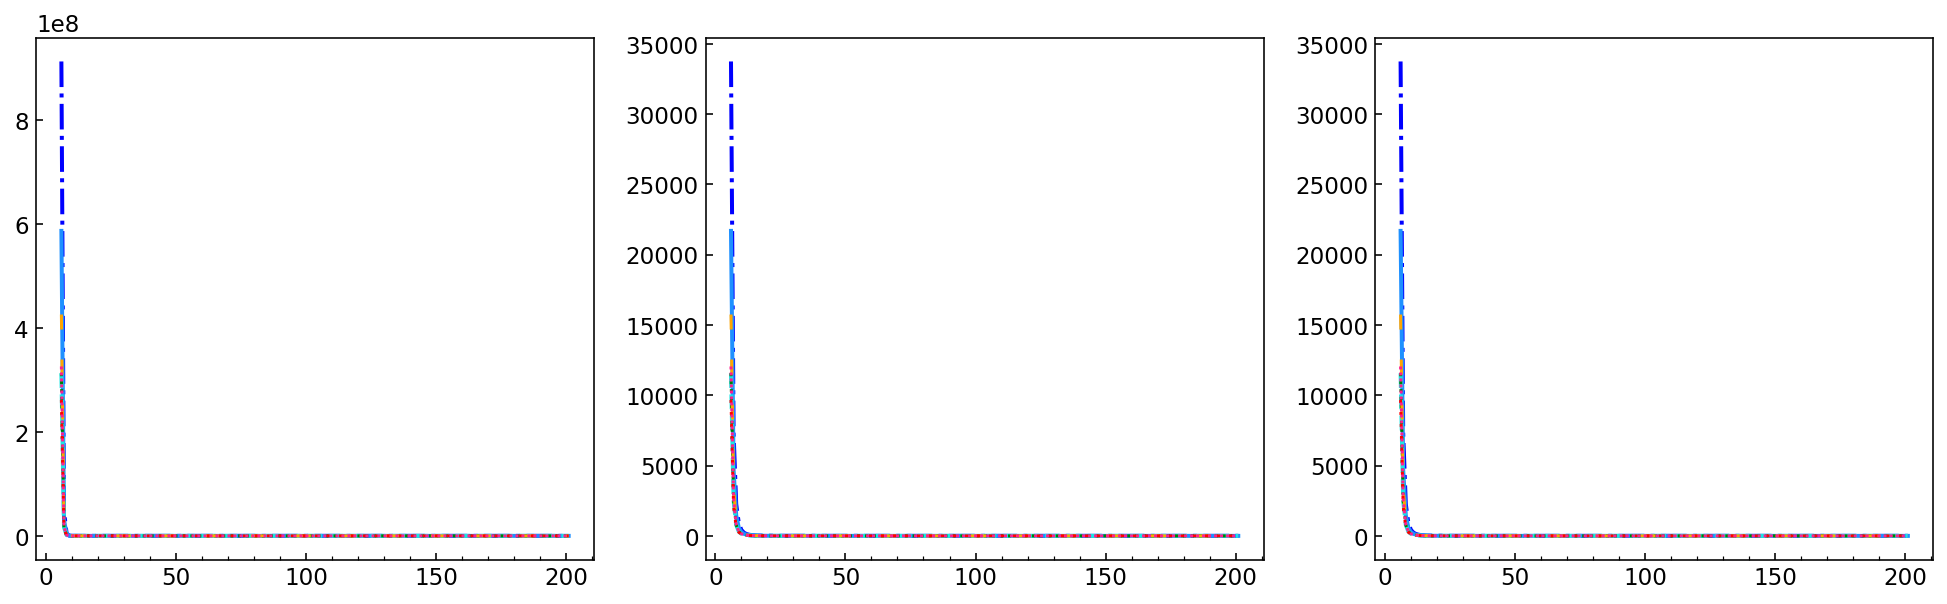

In [19]:
# tau CI21

CI21_to_H2_conversion = lambda tkin, tau: CI21_C_coeff.value * 1e-4 / (X_CO_H2 * X_CI_CO) \
                                          * func_QE_CI(tkin, *CI21_QE_popt) \
                                          * ( tau / (1.0 - np.exp(-tau)) )

if __name__ == '__main__' and '__file__' not in globals():

    #z = 0. # 0. 4. 10.

    top_left_text = '[CI](2-1)'

    out_fig_name = 'Plot_LTE_tau_CI21'

    first_panel_text = r'LTE $\alpha_{\mathrm{C}_{\tt{I}}(2{\tt{-}}1)}^{\neg\,\mathrm{He}} = $' + \
                       r'$C \cdot [Q\,E] \cdot [\tau] \cdot 10^{-4} \, / \, ([\mathrm{C}_{\tt{I}}/\mathrm{H_2}])$'
                       # alphaCI21 function

    fig, popt = make_a_plot_for_tau_term_vs_T_kin(
            z=z, 
            species='CI', 
            transition=1, 
            j_u=2, 
            species_to_H2_conversion=CI21_to_H2_conversion, 
            first_panel_text=first_panel_text, 
            top_left_text=top_left_text, 
            out_fig_name=out_fig_name, 
            return_popt=True,
        )
    
    CI21_T_only_popt = popt


In [ ]:
# Store into json file

json_file = 'out_LTE_alphaCO_alphaCI_new_T_only_approx_popt.json'
if z > 0:
    json_file = json_file.replace('.json', '_z{:g}.json'.format(z))

if __name__ == '__main__' and '__file__' not in globals():
    
    json_data = OrderedDict()
    json_data['CO10_C_coeff'] = (CO10_C_coeff.value, str(CO10_C_coeff.unit))
    json_data['CO10_QE_popt'] = CO10_QE_popt.tolist()
    json_data['CO10_T_only_popt'] = CO10_T_only_popt.tolist()
    json_data['CO21_C_coeff'] = (CO21_C_coeff.value, str(CO21_C_coeff.unit))
    json_data['CO21_QE_popt'] = CO21_QE_popt.tolist()
    json_data['CO21_T_only_popt'] = CO21_T_only_popt.tolist()
    json_data['CI10_C_coeff'] = (CI10_C_coeff.value, str(CI10_C_coeff.unit))
    json_data['CI10_QE_popt'] = CI10_QE_popt.tolist()
    json_data['CI10_T_only_popt'] = CI10_T_only_popt.tolist()
    json_data['CI21_C_coeff'] = (CI21_C_coeff.value, str(CI21_C_coeff.unit))
    json_data['CI21_QE_popt'] = CI21_QE_popt.tolist()
    json_data['CI21_T_only_popt'] = CI21_T_only_popt.tolist()
    if os.path.isfile(json_file):
        shutil.move(json_file, json_file + '.backup')
    with open(json_file, 'w') as fp:
        json.dump(json_data, fp, indent=4)
    print('Output to {!r}'.format(json_file))

else:
    
    print('Loading {!r}'.format(json_file))
    with open(json_file, 'r') as fp:
        json_data = json.load(fp)
        CO10_T_only_popt = json_data['CO10_T_only_popt']
        CO21_T_only_popt = json_data['CO21_T_only_popt']
        CI10_T_only_popt = json_data['CI10_T_only_popt']
        CI21_T_only_popt = json_data['CI21_T_only_popt']

print('CO10_T_only_popt', '=', list2str(CO10_T_only_popt))
print('CO21_T_only_popt', '=', list2str(CO21_T_only_popt))
print('CI10_T_only_popt', '=', list2str(CI10_T_only_popt))
print('CI21_T_only_popt', '=', list2str(CI21_T_only_popt))
print('func_alphaCO10_T_only', '=' , lambda_str_func_alpha_CO(*CO10_T_only_popt))
print('func_alphaCO21_T_only', '=' , lambda_str_func_alpha_CO(*CO21_T_only_popt))
print('func_alphaCI10_T_only', '=' , lambda_str_func_alpha_CI(*CI10_T_only_popt))
print('func_alphaCI21_T_only', '=' , lambda_str_func_alpha_CI(*CI21_T_only_popt))
